TODO:
1. Data size transform
2. Data loader
3. Baseline model
4. Train baseline model
5. NN
6. Train NN (first round)

## Data


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
MyDrive


In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image

import matplotlib.image as mpimg

### Resize (不用重新run）

In [ ]:
def resize_img(f):
  for file in os.listdir(f):
    f_img = f +'/' + file
    img = Image.open(f_img)
    img = img.resize((500,400))
    img.save(f_img)

In [ ]:
classes = ['BACTERIA','NORMAL','VIRUS']
SETS = ['Train','Validation','Test']
for SET in SETS:
  for cls in classes:
    f = '/content/gdrive/MyDrive/APS360project/Data/' + SET + '/' + cls
    resize_img(f)
    print(SET, cls, 'resize done')

In [ ]:
# Small set for the model to overfit
classes = ['BACTERIA','NORMAL','VIRUS']
for cls in classes:
  f = '/content/gdrive/MyDrive/APS360project/Data/Small/' + cls
  resize_img(f)
  print('Small', cls, 'resize done')

Small BACTERIA resize done
Small NORMAL resize done
Small VIRUS resize done


In [ ]:
classes = ['NORMAL', 'PNEUMONIA']
SETS = ['Val_mix','Test_mix', 'Train_mix']
for SET in SETS:
  for cls in classes:
    f = '/content/gdrive/MyDrive/Colab Notebooks/APS360project/Data/' + SET + '/' + cls
    resize_img(f)
    print(SET, cls, 'resize done')

Val_mix NORMAL resize done
Val_mix PNEUMONIA resize done
Test_mix NORMAL resize done
Test_mix PNEUMONIA resize done
Train_mix NORMAL resize done
Train_mix PNEUMONIA resize done


In [ ]:
classes = ['NORMAL', 'PNEUMONIA']
SETS = ['Unseen2']
for SET in SETS:
  for cls in classes:
    f = '/content/gdrive/MyDrive/Colab Notebooks/APS360project/Data/' + SET + '/' + cls
    resize_img(f)
    print(SET, cls, 'resize done')

Unseen2 NORMAL resize done


### Load

In [ ]:
'''
Path for Tim's drive
'''
train_path = '/content/gdrive/MyDrive/APS360project/Data/Train_mix'
valid_path = '/content/gdrive/MyDrive/APS360project/Data/Val_mix'
test_path = '/content/gdrive/MyDrive/APS360project/Data/Test_mix'

# normal vs bacteria path
# train_path = '/content/gdrive/MyDrive/APS360project/Data/Train'
# valid_path = '/content/gdrive/MyDrive/APS360project/Data/Validation'
# test_path = '/content/gdrive/MyDrive/APS360project/Data/Test'

# virus vs bacteria path
# train_path = '/content/gdrive/MyDrive/APS360project/Data/Train2'
# valid_path = '/content/gdrive/MyDrive/APS360project/Data/Validation2'
# test_path = '/content/gdrive/MyDrive/APS360project/Data/Test2'

# train_path = '/content/gdrive/MyDrive/Colab Notebooks/APS360project/Data/Train'
# valid_path = '/content/gdrive/MyDrive/Colab Notebooks/APS360project/Data/Validation'
# test_path = '/content/gdrive/MyDrive/Colab Notebooks/APS360project/Data/Test'

In [ ]:
# Load data from Google Drive
# Transform Settings - Do not use RandomResizedCrop
transform = transforms.Compose([transforms.Resize((500,400)), 
                                transforms.ToTensor()])


trainset = torchvision.datasets.ImageFolder(train_path, transform=transform)
validset = torchvision.datasets.ImageFolder(valid_path, transform=transform)
testset = torchvision.datasets.ImageFolder(test_path, transform=transform)

# Prepare Dataloader
batch_size = 64
num_workers = 1

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

In [ ]:
print("train set size: ", len(trainset))
print("validation set size: ", len(validset)) 
print("test set size: ", len(testset))

train set size:  2216
validation set size:  474
test set size:  476


In [ ]:
# print some imgs to verify
k = 0
for images, labels in trainset:
    # get first img in each batch
    image = images[0]
    print(image.shape)
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    # sub.set_title(classes[labels])
    plt.imshow(img,cmap='gray')

    k += 1
    if k > 14:
        break


### For Transfer Learning (alexnet）

In [1]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [2]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

####Save to folder(不用重新run)

In [ ]:
'''
这个不用重新run
'''
batch_size = 1 # save 1 file at a time, hence batch_size = 1
num_workers = 1
train_transfer_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_transfer_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_transfer_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)



In [ ]:
k = 0
classes = ['NORMAL','PNEUMONIA']
fig = plt.figure()
for images, labels in train_transfer_loader:
    image = images[0]
    #img = np.transpose(image)
    img = np.transpose(image, [1,2,0])
    sub = fig.add_subplot(3, 5, k+1)
    plt.axis('off')
    sub.set_title(classes[labels]) # add label to each image
    plt.imshow(img, cmap='Greys')

    k += 1
    if k > 14:
        break

In [ ]:
'''
这个不用重新run
'''
classes = ['NORMAL','PNEUMONIA']
# save features to folder as tensors
def features_to_folder(loader, path):
    n = 0
    for img, label in loader:
      
      features = alexnet.features(img)
      features_tensor = torch.from_numpy(features.detach().numpy())

      folder_name = path + '/' + str(classes[label])
      if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
      torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
      n += 1


In [ ]:
train_transfer_path = '/content/gdrive/MyDrive/APS360project/Data/Transfer_mix/Train'
valid_transfer_path = '/content/gdrive/MyDrive/APS360project/Data/Transfer_mix/Valid'
test_transfer_path = '/content/gdrive/MyDrive/APS360project/Data/Transfer_mix/Test' 

In [ ]:
'''
这个不用重新run
'''
features_to_folder(train_transfer_loader, train_transfer_path)
features_to_folder(valid_transfer_loader, valid_transfer_path)
features_to_folder(test_transfer_loader, test_transfer_path)

####Load features

In [ ]:
train_transfer_path = '/content/gdrive/MyDrive/APS360project/Data/Transfer_mix/Train'
valid_transfer_path = '/content/gdrive/MyDrive/APS360project/Data/Transfer_mix/Valid'
test_transfer_path = '/content/gdrive/MyDrive/APS360project/Data/Transfer_mix/Test' 

In [ ]:
train_set = torchvision.datasets.DatasetFolder(train_transfer_path, loader=torch.load, extensions=('.tensor'))
valid_set = torchvision.datasets.DatasetFolder(valid_transfer_path, loader=torch.load, extensions=('.tensor'))
test_set = torchvision.datasets.DatasetFolder(test_transfer_path, loader=torch.load, extensions=('.tensor'))

In [ ]:
print("train set size: ", len(train_set))
print("validation set size: ", len(valid_set)) 
print("test set size: ", len(test_set))

train set size:  2216
validation set size:  474
test set size:  476


## Baseline Model

0
RF Test: 0.45999999999999996
1
RF Test: 0.28
2
RF Test: 0.31999999999999995
3
RF Test: 0.26
4
RF Test: 0.41000000000000003
5
RF Test: 0.30000000000000004
6
RF Test: 0.18999999999999995
7
RF Test: 0.64
8
RF Test: 0.36
9
RF Test: 0.18000000000000005
10
RF Test: 0.4
11
RF Test: 0.44999999999999996
12
RF Test: 0.42000000000000004
13
RF Test: 0.4
14
RF Test: 0.36
15


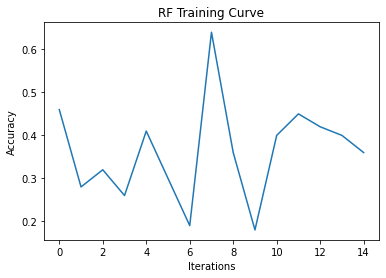

'\n\nclass ANN(nn.Module):\n    def __init__(self):\n        super(ANN, self).__init__()\n        self.layer1 = nn.Linear(1000*800*3, 100)\n        self.layer2 = nn.Linear(100, 3)\n    def forward(self, img):\n        flattened = img.view(-1, 1000*800*3)\n        activation1 = self.layer1(flattened)\n        activation1 = F.relu(activation1)\n        activation2 = self.layer2(activation1)\n        return activation2\n\ndef get_accuracy(model, trainset, valset, train=False):\n    if train:\n        data = trainset\n    else:\n        data = valset\n\n    correct = 0\n    total = 0\n    for imgs, labels in data:\n        \n        output = model(imgs)\n        \n        #select index with maximum prediction score\n        pred = output.max(1, keepdim=True)[1]\n        correct += pred.eq(labels.view_as(pred)).sum().item()\n        total += imgs.shape[0]\n    return correct / total\n\ndef train(model, train_loader, valid_loader, lr, batch_size=64, num_epochs=1):\n    criterion = nn.CrossEn

In [ ]:
# Random Forest
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
train_l= torch.utils.data.DataLoader(trainset, batch_size=100, num_workers=0, shuffle=True)
valid_l= torch.utils.data.DataLoader(validset, batch_size=100, num_workers=0, shuffle=True)
n=0
RF=[]
for i, l in iter(train_l):
# Fit the model to our training data
  model.fit(i.reshape(100,2400000), l)
  print(n)
  n=n+1
  if (n==16):
    break
  for im, lm in iter(valid_l):
# Make predictions
    testing_predicted = model.predict(im.reshape((100,2400000)))
    absolute = abs((testing_predicted-lm.numpy()))
    score = (1-sum(absolute)/len(testing_predicted))
    print("RF Test:", score)
    #if (n==2):
    RF.append(score)
    break
plt.title("RF Training Curve")
plt.plot(range(15), RF, label="Validation Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.show()


'''

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(1000*800*3, 100)
        self.layer2 = nn.Linear(100, 3)
    def forward(self, img):
        flattened = img.view(-1, 1000*800*3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2

def get_accuracy(model, trainset, valset, train=False):
    if train:
        data = trainset
    else:
        data = valset

    correct = 0
    total = 0
    for imgs, labels in data:
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train(model, train_loader, valid_loader, lr, batch_size=64, num_epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            print(loss)
            print(get_accuracy(model, train_loader, valid_loader, train=True))
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_accuracy = get_accuracy(model, train_loader, valid_loader, train=True)# compute training accuracy 
        train_acc.append(train_accuracy) 
        val_acc.append(get_accuracy(model, train_loader, valid_loader, train=False))  # compute validation accuracy
        n += 1
        print("epoch ",n," is ")
        print(train_accuracy)

    # plotting
    """plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()"""

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
model=ANN()
train(model,train_loader,valid_loader,0.01,num_epochs=5)'''

## Primary Model

###Model

In [ ]:
# Use the CNN architecture
# layer 0 => 500 * 400 * 3
# shape equation: ((W - F + 2 * P) / S) + 1
class CNN(nn.Module):
  def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN"
        # CONV1: in channel => 3 (RGB), out_channels => 5, kernal_size => 5, stride => 1, padding => 0
        #   output: 496 * 396 * 10
        self.conv1 = nn.Conv2d(3, 10, 5)
        # MAXPOOL: kernal size => 2, stride => 2
        #   output: 248 * 198 * 10
        self.pool = nn.MaxPool2d(2, 2)
        # CONV2: in_channels => 10, out_channels => 20, kernal_size => 3, stride => 1, padding => 0
        #   output: 246 * 196 * 20
        self.conv2 = nn.Conv2d(10, 20, 3)
        # MAXPOOL: kernal size => 2, stride => 2
        #   output: 123 * 98 * 20
        #FC1: in_features => 123 * 98 * 20, out_features => 32
        self.fc1 = nn.Linear(123 * 98 * 20 , 128)
        #FC2: in_features => 128, out_features => 64
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3) # 3 classes in total

  def forward(self, x):
      #relu function choosen
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 123 * 98 * 20)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x


In [ ]:
# Use the CNN architecture
# layer 0 => 500 * 400 * 3
# shape equation: ((W - F + 2 * P) / S) + 1
class CNN_binary(nn.Module):
  def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN"
        # CONV1: in channel => 3 (RGB), out_channels => 5, kernal_size => 5, stride => 1, padding => 0
        #   output: 496 * 396 * 10
        self.conv1 = nn.Conv2d(3, 10, 5)
        # MAXPOOL: kernal size => 2, stride => 2
        #   output: 248 * 198 * 10
        self.pool = nn.MaxPool2d(2, 2)
        # CONV2: in_channels => 10, out_channels => 20, kernal_size => 3, stride => 1, padding => 0
        #   output: 246 * 196 * 20
        self.conv2 = nn.Conv2d(10, 20, 3)
        # MAXPOOL: kernal size => 2, stride => 2
        #   output: 123 * 98 * 20
        #FC1: in_features => 123 * 98 * 20, out_features => 32
        self.fc1 = nn.Linear(123 * 98 * 20 , 128)
        #FC2: in_features => 128, out_features => 64
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2) # binary

  def forward(self, x):
      #relu function choosen
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 123 * 98 * 20)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

###Functions

In [ ]:
def plot_curve(epoch, train_acc, val_acc, losses, val_loss):
  plt.title("Loss Curve")
  x = range(epoch)
  plt.plot(x, losses, label="Train")
  plt.plot(x, val_loss, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(x, train_acc, label="Train")
  plt.plot(x, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

In [ ]:
def get_accuracy(net, loader):
  correct = 0
  total = 0
  for imgs, labels in loader:
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    output = net(imgs)
    pred = output.max(1, keepdim=True)[1] #select index with maximum prediction score
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]
  return correct / total

In [ ]:
def get_loader(batch_size):
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
  return train_loader, valid_loader

In [ ]:
def train(net, batch_size=64, learning_rate=0.001, num_epochs=30):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    train_loader, valid_loader = get_loader(batch_size)
    path = '/content/gdrive/MyDrive/APS360project/model/'
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Cross Entropy (BCE). 
    # Optimizer will be Adam.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    ########################################################################
    # Set up some numpy arrays to store the training/val loss/accuracy
    train_acc = np.zeros(num_epochs)
    losses = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    start_time = time.time()
    print("Training......")
    n = 0
    first_epoch = True
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        for imgs, labels in iter(train_loader):
          # enable GPU usage, speeding up the training
          if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

          # Forward pass, backward pass, and optimize
          outputs = net(imgs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          if (n % 10) == 0 and first_epoch:
            print(n, " data trained!")
          n += 1
  
        train_acc[epoch] = get_accuracy(net, train_loader)
        losses[epoch] = float(loss) / batch_size
        val_acc[epoch] = get_accuracy(net, valid_loader)
        print(("Epoch: {}, Train acc: {}, Loss: {} |"+
               "Validation acc: {}").format(
                   epoch,
                   train_acc[epoch],
                   losses[epoch],
                   val_acc[epoch]))
        first_epoch = False
    model_path = "{0}model_{1}_bs{2}_lr{3}_epoch{4}".format(path, model.name, batch_size, learning_rate, num_epochs)
    torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    return train_acc, val_acc, losses

In [ ]:
def get_finalValLoss(net, criterion, loader, batch_size=64):
  for imgs1, lables1 in iter(valid_loader):
      if torch.cuda.is_available():
        imgs1 = imgs1.cuda()
        lables1 = lables1.cuda()
      outputs_valid = net(imgs1)
      loss_v = criterion(outputs_valid, lables1)
  result = float(loss_v) / batch_size
  return result

In [ ]:
def train_withloss(net, batch_size=64, learning_rate=0.001, num_epochs=30):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    train_loader, valid_loader = get_loader(batch_size)
    path = '/content/gdrive/MyDrive/APS360project/model/'
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Cross Entropy (BCE). 
    # Optimizer will be Adam.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    ########################################################################
    # Set up some numpy arrays to store the training/val loss/accuracy
    train_acc = np.zeros(num_epochs)
    losses = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    start_time = time.time()
    print("Training......")
    n = 0
    first_epoch = True
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        for imgs, labels in iter(train_loader):
          # enable GPU usage, speeding up the training
          if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

          # Forward pass, backward pass, and optimize
          outputs = net(imgs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          if (n % 10) == 0 and first_epoch:
            print(n, " data trained!")
          n += 1
        for imgs1, lables1 in iter(valid_loader):
          if use_cuda and torch.cuda.is_available():
            imgs1 = imgs1.cuda()
            lables1 = lables1.cuda()
          outputs_valid = net(imgs1)
          loss_v = criterion(outputs_valid, lables1)
          
        train_acc[epoch] = get_accuracy(net, train_loader)
        losses[epoch] = float(loss) / batch_size
        val_acc[epoch] = get_accuracy(net, valid_loader)
        val_loss[epoch] = float(loss_v) / batch_size
        print(("Epoch: {}, Train acc: {}, Loss: {} |"+
               "Validation acc: {}, Loss: {}").format(
                   epoch,
                   train_acc[epoch],
                   losses[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))
        first_epoch = False
    model_path = "{0}model_{1}_bs{2}_lr{3}_epoch{4}".format(path, model.name, batch_size, learning_rate, num_epochs)
    torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    return train_acc, val_acc, losses, val_loss

In [ ]:
#torch.cuda.is_available()
torch.cuda.empty_cache()

In [ ]:
classes = ['BACTERIA','NORMAL','VIRUS']
k = 0
fig = plt.figure()
for images, labels in train_loader:
    image = images[0]
    #img = np.transpose(image)
    img = np.transpose(image, [1,2,0])
    sub = fig.add_subplot(3, 5, k+1)
    plt.axis('off')
    sub.set_title(classes[labels]) # add label to each image
    plt.imshow(img, cmap='Greys')

    k += 1
    if k > 14:
        break

###Training results

CUDA is available!  Training on GPU ...
Training......
0  data trained!
10  data trained!
20  data trained!
30  data trained!
40  data trained!
50  data trained!
60  data trained!
Epoch: 0, Train acc: 0.8346379647749511, Loss: 0.007026348263025284 |Validation acc: 0.5493273542600897
Epoch: 1, Train acc: 0.8559197651663405, Loss: 0.007756379898637533 |Validation acc: 0.5661434977578476
Epoch: 2, Train acc: 0.8850293542074364, Loss: 0.004406394902616739 |Validation acc: 0.5145739910313901
Epoch: 3, Train acc: 0.913894324853229, Loss: 0.002828985918313265 |Validation acc: 0.49887892376681614
Epoch: 4, Train acc: 0.9344422700587084, Loss: 0.004041566047817469 |Validation acc: 0.4910313901345291
Epoch: 5, Train acc: 0.934931506849315, Loss: 0.004330284893512726 |Validation acc: 0.484304932735426
Epoch: 6, Train acc: 0.9540117416829745, Loss: 0.0026843787636607885 |Validation acc: 0.4943946188340807
Epoch: 7, Train acc: 0.9214774951076321, Loss: 0.0019235404906794429 |Validation acc: 0.48094

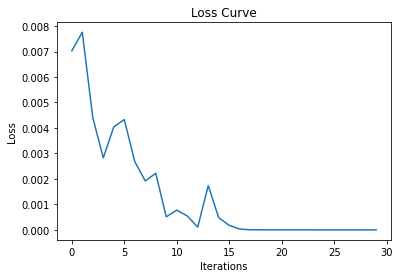

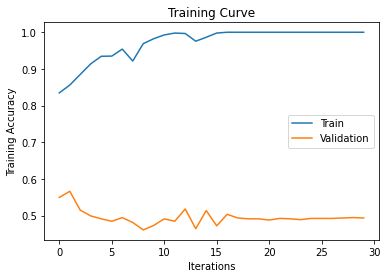

In [ ]:
use_cuda = True

model = CNN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train(model, train_loader, valid_loader, batch_size=64, learning_rate=0.001, num_epochs=30)
plot_curve(30, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
0  data trained!
10  data trained!
20  data trained!
30  data trained!
40  data trained!
50  data trained!
60  data trained!
Epoch: 0, Train acc: 0.7568493150684932, Loss: 0.016488024964928627 |Validation acc: 0.6984304932735426
Epoch: 1, Train acc: 0.836105675146771, Loss: 0.015870293602347374 |Validation acc: 0.6210762331838565
Epoch: 2, Train acc: 0.8669275929549902, Loss: 0.010008719749748707 |Validation acc: 0.5526905829596412
Epoch: 3, Train acc: 0.9026418786692759, Loss: 0.006649807095527649 |Validation acc: 0.492152466367713
Epoch: 4, Train acc: 0.923679060665362, Loss: 0.006833827588707209 |Validation acc: 0.4977578475336323
Epoch: 5, Train acc: 0.9302837573385518, Loss: 0.00830251257866621 |Validation acc: 0.4899103139013453
Epoch: 6, Train acc: 0.9537671232876712, Loss: 0.006362854037433863 |Validation acc: 0.4820627802690583
Epoch: 7, Train acc: 0.9801859099804305, Loss: 0.003384075593203306 |Validation acc: 0.502242152

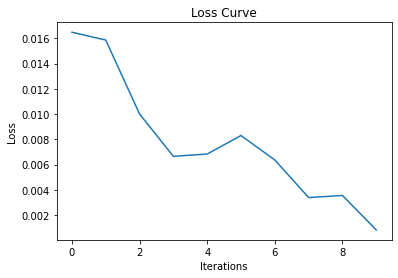

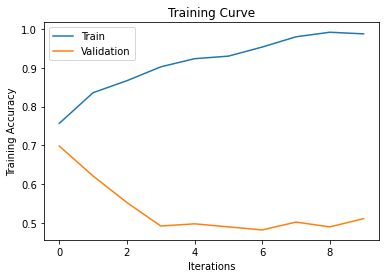

In [ ]:
use_cuda = True

model = CNN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train(model, train_loader, valid_loader, batch_size=32, learning_rate=0.001, num_epochs=10)
plot_curve(10, train_acc, val_acc, losses)

In [ ]:
acc = get_accuracy(model, test_loader)
print(acc)

0.5787671232876712


CUDA is available!  Training on GPU ...
Training......
0  data trained!
10  data trained!
20  data trained!
30  data trained!
40  data trained!
Epoch: 0, Train acc: 0.7312539382482671, Loss: 0.007789916824549437 |Validation acc: 0.6125356125356125
Epoch: 1, Train acc: 0.853182104599874, Loss: 0.0051519013941287994 |Validation acc: 0.5683760683760684
Epoch: 2, Train acc: 0.8802772526780088, Loss: 0.005842921789735556 |Validation acc: 0.5641025641025641
Epoch: 3, Train acc: 0.8733459357277883, Loss: 0.0045371889136731625 |Validation acc: 0.5868945868945868
Epoch: 4, Train acc: 0.8720856962822936, Loss: 0.004002811852842569 |Validation acc: 0.6196581196581197
Epoch: 5, Train acc: 0.8714555765595463, Loss: 0.005098727066069841 |Validation acc: 0.6054131054131054
Epoch: 6, Train acc: 0.924700693131695, Loss: 0.0028637105133384466 |Validation acc: 0.5740740740740741
Epoch: 7, Train acc: 0.921865154379332, Loss: 0.0024788801092654467 |Validation acc: 0.5883190883190883
Epoch: 8, Train acc: 0.

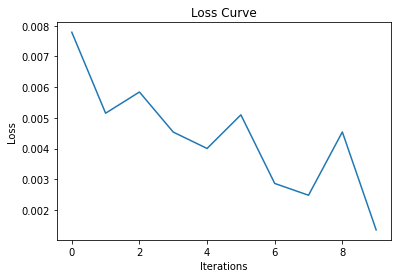

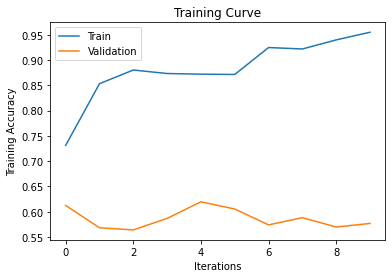

In [ ]:
use_cuda = True

model = CNN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train(model, batch_size=64, learning_rate=0.001, num_epochs=10)
plot_curve(10, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
0  data trained!
10  data trained!
20  data trained!
Epoch: 0, Train acc: 0.6603654694391935, Loss: 0.005161565262824297 |Validation acc: 0.5683760683760684
Epoch: 1, Train acc: 0.8084436042848141, Loss: 0.004212850704789162 |Validation acc: 0.6054131054131054
Epoch: 2, Train acc: 0.8468809073724007, Loss: 0.002850112970918417 |Validation acc: 0.6225071225071225
Epoch: 3, Train acc: 0.8752362948960303, Loss: 0.002632936928421259 |Validation acc: 0.5826210826210826
Epoch: 4, Train acc: 0.889413988657845, Loss: 0.002027990063652396 |Validation acc: 0.5982905982905983
Epoch: 5, Train acc: 0.9149338374291115, Loss: 0.00224197655916214 |Validation acc: 0.594017094017094
Epoch: 6, Train acc: 0.9174543163201008, Loss: 0.0016911873826757073 |Validation acc: 0.6025641025641025
Epoch: 7, Train acc: 0.9127284183994959, Loss: 0.0017092961352318525 |Validation acc: 0.603988603988604
Epoch: 8, Train acc: 0.9436042848141147, Loss: 0.0013718273257

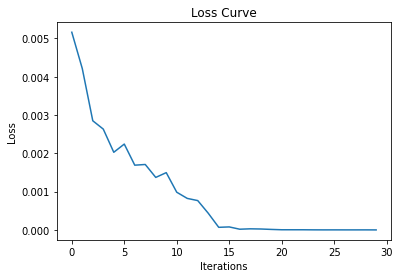

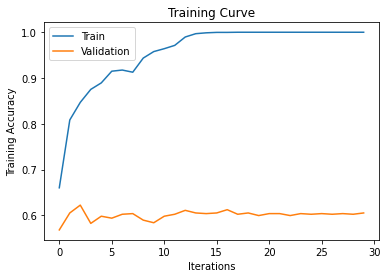

In [ ]:
use_cuda = True

model = CNN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train(model, batch_size=128, learning_rate=0.001, num_epochs=30)
plot_curve(30, train_acc, val_acc, losses)

##Alexnet

###Models

In [ ]:
class Alex_NN(nn.Module):
      def __init__(self):
          self.name = "Alex_NN"
          super(Alex_NN, self).__init__()
          self.fc1 = nn.Linear(256*14*11, 2000)
          self.fc2 = nn.Linear(2000, 100)
          self.fc3 = nn.Linear(100, 3)

      def forward(self, x):
          x = x.view(-1, 256*14*11)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = self.fc3(x)
          return x

In [ ]:
'''
Prevent Overfitting:
  Data Normolization
  Data Argumentation
  Weight Decay
  Model Averaging
  Dropout
'''

'\nPrevent Overfitting:\n  Data Normolization\n  Data Argumentation\n  Weight Decay\n  Model Averaging\n  Dropout\n'

In [ ]:
class Alex_NN_Dropout(nn.Module):
      
      
      def __init__(self):
          self.name = "Alex_NN_Dropout"
          super(Alex_NN_Dropout, self).__init__()
          self.fc1 = nn.Linear(256*14*11, 2000)
          self.fc2 = nn.Linear(2000, 100)
          self.fc3 = nn.Linear(100, 3)
          self.dropout1 = nn.Dropout(0.4) # drop out layer with 20% dropped out neuron
          self.dropout2 = nn.Dropout(0.4)
          self.dropout3 = nn.Dropout(0.4)

      def forward(self, x):
          x = x.view(-1, 256*14*11)
          x = F.relu(self.fc1(self.dropout1(x)))
          x = F.relu(self.fc2(self.dropout2(x)))
          x = self.fc3(self.dropout3(x))
          return x
          

###Training Functions

In [ ]:
# function for training
def train_alex(model, trainset, validset, batch_size=32, learning_rate=0.001, num_epochs=1,path=''):
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_acc, losses,val_acc, val_loss,epoches = [],[],[],[],[]

    start_time = time.time()
    print("Training......")
    # training
    epoch = 0 # the number of iterations
    for epoch in range(num_epochs):
        for features, labels in iter(train_loader):        

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              features = features.cuda()
              labels = labels.cuda()
              
            #############################################  
              
            out = model(features)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
        for features1, labels1 in iter(valid_loader):        

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              features1 = features1.cuda()
              labels1 = labels1.cuda()
              
            #############################################  
              
            out1 = model(features1)             # forward pass
            loss_v = criterion(out1, labels1) # compute the total loss
  
        # save the current training information
        epoches.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy       
        val_acc.append(get_accuracy(model, valid_loader))  # compute validation accuracy
        val_loss.append(float(loss_v)/batch_size)
        
        print(("Epoch {}: Train accuracy: {}, Train loss: {} | Validation accuracy: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   losses[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))
        
        model_path = "{0}model_{1}_bs{2}_lr{3}_epoch{4}".format(path, model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))   
    return train_acc, val_acc, losses,val_loss


In [ ]:
# function for training with noise
def train_alex_noise(model, trainset, validset, batch_size=32, learning_rate=0.001, num_epochs=1,path=''):
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_acc, losses,val_acc, epoches = [],[],[],[]

    start_time = time.time()
    print("Training......")
    # training
    epoch = 0 # the number of iterations
    noise = 0.5
    for epoch in range(num_epochs):
        for features, labels in iter(train_loader):        

            feature_noisy = features + noise * torch.randn(*features.shape)
            feature_noisy = np.clip(feature_noisy, 0., 1.)
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              feature_noisy = feature_noisy.cuda()
              labels = labels.cuda()
              
            #############################################  
            

            out = model(feature_noisy)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

  
        # save the current training information
        epoches.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy       
        val_acc.append(get_accuracy(model, valid_loader))  # compute validation accuracy
        
        print(("Epoch {}: Train accuracy: {}, Train loss: {} | Validation accuracy: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   losses[epoch],
                   val_acc[epoch]))
        
        model_path = "{0}model_{1}_bs{2}_lr{3}_epoch{4}".format(path, model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))   
    return train_acc, val_acc, losses

###Training Result

CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.8774214036201969, Train loss: 0.002001495799049735 | Validation accuracy: 0.6438746438746439
Epoch 2: Train accuracy: 0.9009209272785011, Train loss: 0.005664655938744545 | Validation accuracy: 0.5897435897435898
Epoch 3: Train accuracy: 0.9599872975547793, Train loss: 0.0008006681455299258 | Validation accuracy: 0.6182336182336182
Epoch 4: Train accuracy: 0.9790409653858367, Train loss: 0.001454909099265933 | Validation accuracy: 0.6282051282051282
Epoch 5: Train accuracy: 0.9939663385201651, Train loss: 0.0005670027458108962 | Validation accuracy: 0.6296296296296297
Epoch 6: Train accuracy: 0.9892029215624007, Train loss: 0.0005968620534986258 | Validation accuracy: 0.6310541310541311
Epoch 7: Train accuracy: 1.0, Train loss: 3.217434641555883e-05 | Validation accuracy: 0.6210826210826211
Epoch 8: Train accuracy: 0.9996824388694824, Train loss: 0.0005088559701107442 | Validation accuracy: 0.623931623931

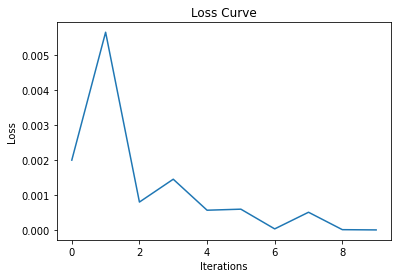

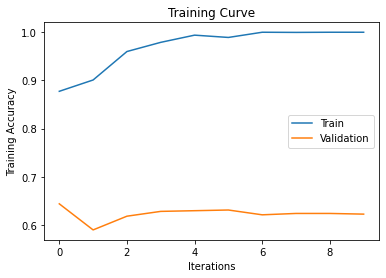

In [ ]:
use_cuda = True

model = Alex_NN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train_alex(model, train_set, valid_set, batch_size=64, learning_rate=0.001, num_epochs=10)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(10, train_acc, val_acc, losses)

In [ ]:
print(len(train_set))
print(len(valid_set))

3149
702


CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.8053350269926961, Train loss: 0.006633436307311058 | Validation accuracy: 0.6509971509971509
Epoch 2: Train accuracy: 0.8678945697046682, Train loss: 0.0023437892086803913 | Validation accuracy: 0.6324786324786325
Epoch 3: Train accuracy: 0.8729755477929502, Train loss: 0.0027363302651792765 | Validation accuracy: 0.6239316239316239
Epoch 4: Train accuracy: 0.9047316608447126, Train loss: 0.004234412685036659 | Validation accuracy: 0.6054131054131054
Epoch 5: Train accuracy: 0.8783740870117498, Train loss: 0.007326625287532806 | Validation accuracy: 0.6182336182336182
Epoch 6: Train accuracy: 0.8831375039695142, Train loss: 0.005714301951229572 | Validation accuracy: 0.6296296296296297
Epoch 7: Train accuracy: 0.9288663067640521, Train loss: 0.004854149185121059 | Validation accuracy: 0.5968660968660968
Epoch 8: Train accuracy: 0.9396633852016513, Train loss: 0.0014338336186483502 | Validation accuracy: 0

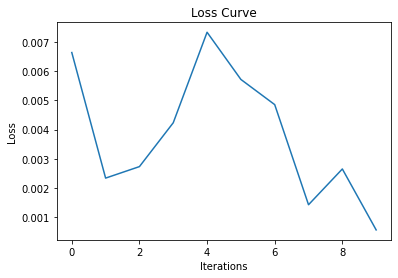

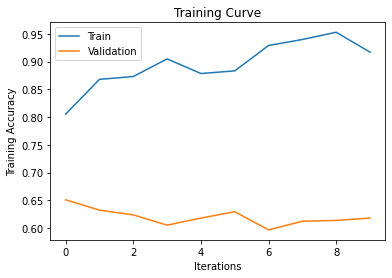

In [ ]:
'''
Dropout
'''

use_cuda = True

model = Alex_NN_Dropout()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train_alex(model, train_set, valid_set, batch_size=64, learning_rate=0.001, num_epochs=10)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(10, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.5874880914576056, Train loss: 0.015863681212067604 | Validation accuracy: 0.4672364672364672
Epoch 2: Train accuracy: 0.7729437916798984, Train loss: 0.012301553972065449 | Validation accuracy: 0.6709401709401709
Epoch 3: Train accuracy: 0.7577008574150524, Train loss: 0.011067108251154423 | Validation accuracy: 0.6595441595441596
Epoch 4: Train accuracy: 0.7869164814226739, Train loss: 0.009408003650605679 | Validation accuracy: 0.6652421652421653
Epoch 5: Train accuracy: 0.7910447761194029, Train loss: 0.002046907553449273 | Validation accuracy: 0.6638176638176638
Epoch 6: Train accuracy: 0.7894569704668148, Train loss: 0.012138142250478268 | Validation accuracy: 0.6623931623931624
Epoch 7: Train accuracy: 0.7977135598602731, Train loss: 0.005084409844130278 | Validation accuracy: 0.6296296296296297
Epoch 8: Train accuracy: 0.7973959987297555, Train loss: 0.00677806232124567 | Validation accuracy: 0.655

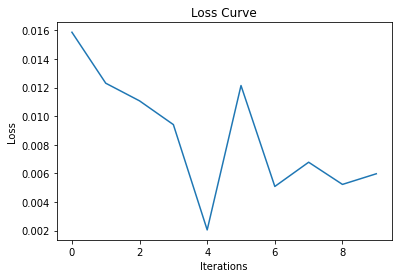

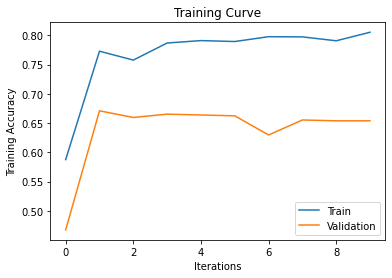

In [ ]:
use_cuda = True

model = Alex_NN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train_alex_noise(model, train_set, valid_set, batch_size=64, learning_rate=0.001, num_epochs=10)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(10, train_acc, val_acc, losses)

# Updated baseline model



In [ ]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
def baseline():
  model = RandomForestClassifier()
  train_l= torch.utils.data.DataLoader(trainset, batch_size=2129, num_workers=0, shuffle=True)
  valid_l= torch.utils.data.DataLoader(validset, batch_size=478, num_workers=0, shuffle=True)
  RF=[]
  for i, l in iter(train_l):
  # Fit the model to our training data
    model.fit(i.reshape(2129,600000), l)
  for im, lm in iter(valid_l):
    # Make predictions
    testing_predicted = model.predict(im.reshape((478,600000)))
    absolute = abs((testing_predicted-lm.numpy()))
    score = (1-sum(absolute)/len(testing_predicted))
    print("RF Test:", score)
    RF.append(score)
    return
baseline()

RF Test: 0.8221757322175732


# Updated CNN model

In [ ]:
# Use the CNN architecture
# layer 0 => 500 * 400 * 3
# shape equation: ((W - F + 2 * P) / S) + 1
class CNN_binary(nn.Module):
  def __init__(self):
        super(CNN_binary, self).__init__()
        self.name = "CNN_binary"
        # CONV1: in channel => 3 (RGB), out_channels => 5, kernal_size => 5, stride => 1, padding => 0
        #   output: 496 * 396 * 10
        self.conv1 = nn.Conv2d(3, 10, 5)
        # MAXPOOL: kernal size => 2, stride => 2
        #   output: 248 * 198 * 10
        self.pool = nn.MaxPool2d(2, 2)
        # CONV2: in_channels => 10, out_channels => 20, kernal_size => 3, stride => 1, padding => 0
        #   output: 246 * 196 * 20
        self.conv2 = nn.Conv2d(10, 20, 3)
        # MAXPOOL: kernal size => 2, stride => 2
        #   output: 123 * 98 * 20
        #FC1: in_features => 123 * 98 * 20, out_features => 32
        self.fc1 = nn.Linear(123 * 98 * 20 , 128)
        #FC2: in_features => 128, out_features => 64
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2) # binary

  def forward(self, x):
      #relu function choosen
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 123 * 98 * 20)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [ ]:
class CNN_binary_small(nn.Module):
  def __init__(self):
        super(CNN_binary_small, self).__init__()
        self.name = "CNN_binary_small"
        # CONV1: in channel => 3 (RGB), out_channels => 5, kernal_size => 5, stride => 1, padding => 0
        #   output: 496 * 396 * 10
        self.conv1 = nn.Conv2d(3, 10, 5)
        # MAXPOOL: kernal size => 2, stride => 2
        #   output: 248 * 198 * 10
        self.pool = nn.MaxPool2d(2, 2)
        # CONV2: in_channels => 10, out_channels => 20, kernal_size => 3, stride => 1, padding => 0
        #   output: 246 * 196 * 20
        self.conv2 = nn.Conv2d(10, 20, 3)
        # MAXPOOL: kernal size => 2, stride => 2
        #   output: 123 * 98 * 20
        #FC1: in_features => 123 * 98 * 20, out_features => 32
        self.fc1 = nn.Linear(123 * 98 * 20 , 128)
        #FC2: in_features => 128, out_features => 64
        self.fc2 = nn.Linear(128, 2)

  def forward(self, x):
      #relu function choosen
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 123 * 98 * 20)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

## Training Result

In [ ]:
use_cuda = True

model = CNN_binary()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train(model, batch_size=64, learning_rate=0.001, num_epochs=30)
plot_curve(30, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
0  data trained!
10  data trained!
20  data trained!
30  data trained!
Epoch: 0, Train acc: 0.8882104274307187, Loss: 0.0037630191072821617 |Validation acc: 0.7112970711297071
Epoch: 1, Train acc: 0.9596054485674025, Loss: 0.0026276297867298126 |Validation acc: 0.8661087866108786
Epoch: 2, Train acc: 0.9675904180366369, Loss: 0.0011241075117141008 |Validation acc: 0.8347280334728033
Epoch: 3, Train acc: 0.9755753875058712, Loss: 0.0005737610044889152 |Validation acc: 0.9037656903765691
Epoch: 4, Train acc: 0.9788633161108502, Loss: 0.002383024198934436 |Validation acc: 0.9058577405857741
Epoch: 5, Train acc: 0.9614842649131048, Loss: 0.0010669920593500137 |Validation acc: 0.7824267782426778
Epoch: 6, Train acc: 0.9859088774072334, Loss: 0.00011879700468853116 |Validation acc: 0.897489539748954
Epoch: 7, Train acc: 0.9830906528886801, Loss: 0.00012087674258509651 |Validation acc: 0.8410041841004184
Epoch: 8, Train acc: 0.97604509159

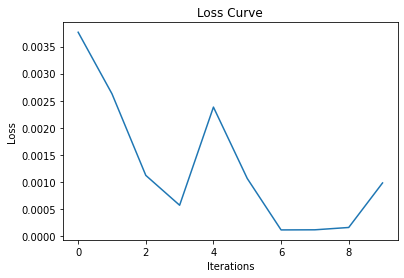

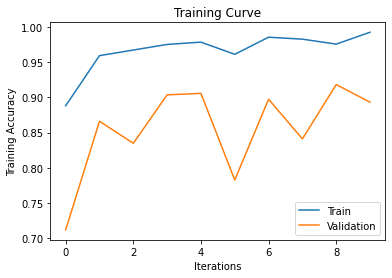

In [ ]:
use_cuda = True

model = CNN_binary()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train(model, batch_size=64, learning_rate=0.0001, num_epochs=10)
plot_curve(10, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
0  data trained!
10  data trained!
Epoch: 0, Train acc: 0.9337717238139972, Loss: 0.001885301317088306 |Validation acc: 0.8744769874476988
Epoch: 1, Train acc: 0.9596054485674025, Loss: 0.0007719328277744353 |Validation acc: 0.9142259414225942
Epoch: 2, Train acc: 0.9563175199624236, Loss: 0.0007546462002210319 |Validation acc: 0.7824267782426778
Epoch: 3, Train acc: 0.9751056834194457, Loss: 0.0003593699657358229 |Validation acc: 0.8410041841004184
Epoch: 4, Train acc: 0.963363081258807, Loss: 0.000601702427957207 |Validation acc: 0.9121338912133892
Epoch: 5, Train acc: 0.9802724283701268, Loss: 0.0002137468836735934 |Validation acc: 0.8347280334728033
Epoch: 6, Train acc: 0.9943635509628934, Loss: 0.00016705079178791493 |Validation acc: 0.9058577405857741
Epoch: 7, Train acc: 0.6369187411930484, Loss: 0.00018882984295487404 |Validation acc: 0.5230125523012552
Epoch: 8, Train acc: 0.9488022545796149, Loss: 0.0022758785635232925 |V

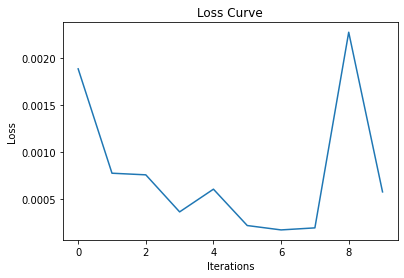

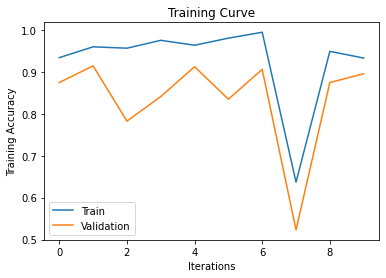

In [ ]:
use_cuda = True

model = CNN_binary()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train(model, batch_size=128, learning_rate=0.001, num_epochs=10)
plot_curve(10, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
0  data trained!
10  data trained!
Epoch: 0, Train acc: 0.8548614372945045, Loss: 0.002887110924348235 |Validation acc: 0.6882845188284519
Epoch: 1, Train acc: 0.9361202442461249, Loss: 0.0008731601992622018 |Validation acc: 0.7782426778242678
Epoch: 2, Train acc: 0.9652418976045092, Loss: 0.000780425441917032 |Validation acc: 0.8347280334728033
Epoch: 3, Train acc: 0.9544387036167215, Loss: 0.0005415644263848662 |Validation acc: 0.9016736401673641
Epoch: 4, Train acc: 0.937059652418976, Loss: 0.0011079467367380857 |Validation acc: 0.897489539748954
Epoch: 5, Train acc: 0.9840300610615312, Loss: 0.0005530526395887136 |Validation acc: 0.8744769874476988
Epoch: 6, Train acc: 0.9868482855800845, Loss: 0.0002600364969111979 |Validation acc: 0.899581589958159
Epoch: 7, Train acc: 0.9901362141850634, Loss: 0.0002124272723449394 |Validation acc: 0.8786610878661087
Epoch: 8, Train acc: 0.9854391733208079, Loss: 0.0005282509955577552 |Valid

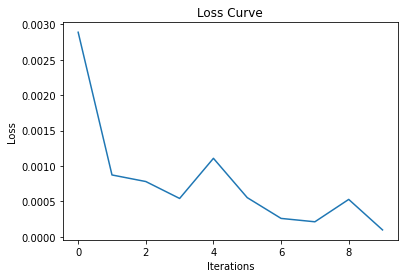

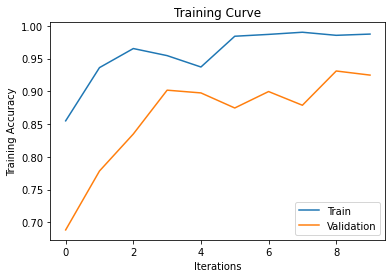

In [ ]:
use_cuda = True

model = CNN_binary()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train(model, batch_size=128, learning_rate=0.001, num_epochs=10)
plot_curve(10, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
0  data trained!
10  data trained!
Epoch: 0, Train acc: 0.9116956317519962, Loss: 0.0025017850566655397 |Validation acc: 0.7217573221757322
Epoch: 1, Train acc: 0.9638327853452325, Loss: 0.0007879509357735515 |Validation acc: 0.8807531380753139
Epoch: 2, Train acc: 0.9605448567402537, Loss: 0.0006938767619431019 |Validation acc: 0.797071129707113
Epoch: 3, Train acc: 0.982151244715829, Loss: 0.0004085367254447192 |Validation acc: 0.8807531380753139
Epoch: 4, Train acc: 0.9877876937529356, Loss: 0.0008934574434533715 |Validation acc: 0.899581589958159
Epoch: 5, Train acc: 0.986378581493659, Loss: 0.00024377391673624516 |Validation acc: 0.8765690376569037
Epoch: 6, Train acc: 0.9920150305307656, Loss: 0.0001375441934214905 |Validation acc: 0.9205020920502092
Epoch: 7, Train acc: 0.9920150305307656, Loss: 0.00012030448124278337 |Validation acc: 0.9079497907949791
Epoch: 8, Train acc: 0.9967120713950212, Loss: 0.0003535365976858884 |Va

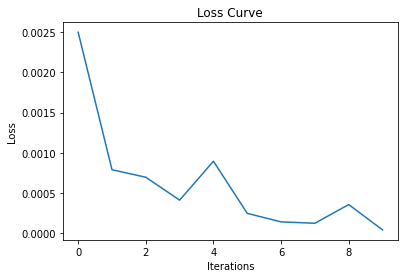

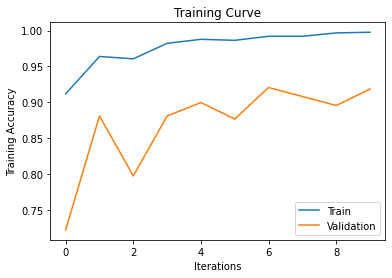

In [ ]:
use_cuda = True

model = CNN_binary()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train(model, batch_size=128, learning_rate=0.001, num_epochs=10)
plot_curve(10, train_acc, val_acc, losses)

##Testing


In [ ]:
print("test accuracy: ", get_accuracy(model, test_loader))

test accuracy:  0.7945492662473794


In [ ]:
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, 
                                          num_workers=num_workers, shuffle=True)

best_CNNmodel = CNN_binary()
best_model_path = "/content/gdrive/MyDrive/APS360project/model/model_CNN_binary_bs128_lr0.001_epoch9"
best_CNNmodel.load_state_dict(torch.load(best_model_path))
best_CNNmodel.cuda()
print("test accuracy: ", get_accuracy(best_CNNmodel, test_loader))

test accuracy:  0.7945492662473794


##MIXED DATA


CUDA is not available.  Training on CPU ...
Training......
0  data trained!
10  data trained!
20  data trained!
30  data trained!
40  data trained!
50  data trained!
60  data trained!
70  data trained!
80  data trained!
90  data trained!
100  data trained!
110  data trained!
120  data trained!
130  data trained!
Epoch: 0, Train acc: 0.9246389891696751, Loss: 0.009598265402019024 |Validation acc: 0.9345991561181435, Loss: 0.004902193788439035
Epoch: 1, Train acc: 0.9417870036101083, Loss: 0.012833205051720142 |Validation acc: 0.9345991561181435, Loss: 0.00861834641546011
Epoch: 2, Train acc: 0.9499097472924187, Loss: 0.0008299756445921957 |Validation acc: 0.9367088607594937, Loss: 0.011280887760221958
Epoch: 3, Train acc: 0.9548736462093863, Loss: 0.007046287879347801 |Validation acc: 0.9345991561181435, Loss: 0.0008369052084162831
Epoch: 4, Train acc: 0.9657039711191335, Loss: 0.0015173048013821244 |Validation acc: 0.9472573839662447, Loss: 0.0061169760301709175
Epoch: 5, Train acc: 0.

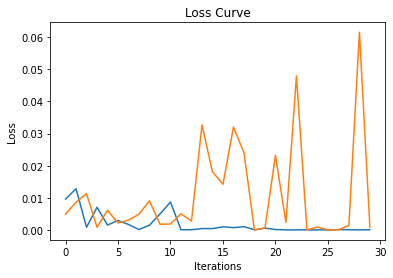

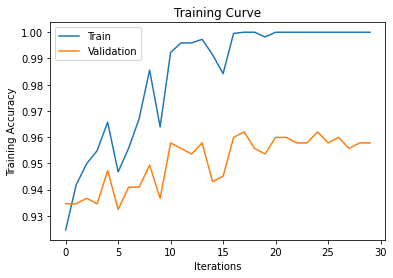

In [ ]:
use_cuda = False

model = CNN_binary()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#Tunning hyperparameters
train_acc, val_acc, losses, val_loss = train_withloss(model, batch_size=16, learning_rate=0.0001, num_epochs=30)
#train_acc, val_acc, losses = train(model, batch_size=128, learning_rate=0.001, num_epochs=10)
plot_curve(30, train_acc, val_acc, losses, val_loss)

CUDA is not available.  Training on CPU ...
Training......
0  data trained!
10  data trained!
20  data trained!
30  data trained!
40  data trained!
50  data trained!
60  data trained!
Epoch: 0, Train acc: 0.9341155234657039, Loss: 0.00552034517750144 |Validation acc: 0.9240506329113924, Loss: 0.003900308394804597
Epoch: 1, Train acc: 0.9535198555956679, Loss: 0.004450543317943811 |Validation acc: 0.9324894514767933, Loss: 0.004402938764542341
Epoch: 2, Train acc: 0.9666064981949458, Loss: 0.00016331352526322007 |Validation acc: 0.930379746835443, Loss: 0.003321451134979725
Epoch: 3, Train acc: 0.9661552346570397, Loss: 0.004470205865800381 |Validation acc: 0.9367088607594937, Loss: 0.002032049000263214
Epoch: 4, Train acc: 0.9796931407942239, Loss: 0.0002122452133335173 |Validation acc: 0.9430379746835443, Loss: 0.010340660810470581
Epoch: 5, Train acc: 0.9580324909747292, Loss: 0.0010182297555729747 |Validation acc: 0.9388185654008439, Loss: 0.00318363425321877
Epoch: 6, Train acc: 0.

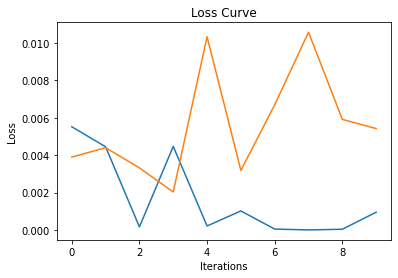

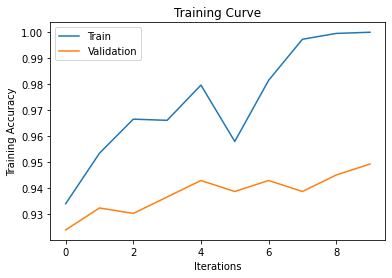

In [ ]:
use_cuda = False

model = CNN_binary()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#Tunning hyperparameters
train_acc, val_acc, losses, val_loss = train_withloss(model, batch_size=32, learning_rate=0.001, num_epochs=10)
#train_acc, val_acc, losses = train(model, batch_size=128, learning_rate=0.001, num_epochs=10)
plot_curve(10, train_acc, val_acc, losses, val_loss)

CUDA is available!  Training on GPU ...
Training......
0  data trained!
10  data trained!
Epoch: 0, Train acc: 0.9088447653429603, Loss: 0.002160016680136323 |Validation acc: 0.9282700421940928
Epoch: 1, Train acc: 0.9332129963898917, Loss: 0.0007025384111329913 |Validation acc: 0.9324894514767933
Epoch: 2, Train acc: 0.9481046931407943, Loss: 0.002415426541119814 |Validation acc: 0.9409282700421941
Epoch: 3, Train acc: 0.9458483754512635, Loss: 0.0005803683307021856 |Validation acc: 0.9388185654008439
Epoch: 4, Train acc: 0.9530685920577617, Loss: 0.0010160929523408413 |Validation acc: 0.9367088607594937
Epoch: 5, Train acc: 0.953971119133574, Loss: 0.001407477306202054 |Validation acc: 0.9430379746835443
Epoch: 6, Train acc: 0.9449458483754513, Loss: 0.0015253472374752164 |Validation acc: 0.9388185654008439
Epoch: 7, Train acc: 0.9422382671480144, Loss: 0.0002639219746924937 |Validation acc: 0.9282700421940928
Epoch: 8, Train acc: 0.9697653429602888, Loss: 0.0009727628785185516 |Vali

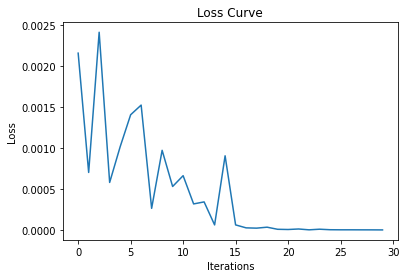

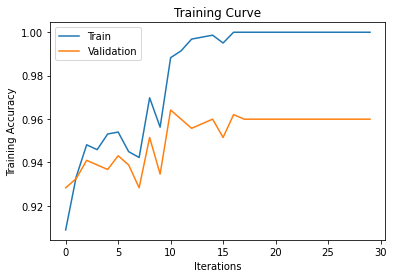

In [ ]:
use_cuda = True

model = CNN_binary()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train(model, batch_size=128, learning_rate=0.001, num_epochs=30)
plot_curve(30, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
0  data trained!
10  data trained!
20  data trained!
30  data trained!
Epoch: 0, Train acc: 0.8745487364620939, Loss: 0.009478292427957058 |Validation acc: 0.8776371308016878
Epoch: 1, Train acc: 0.8813176895306859, Loss: 0.007749906275421381 |Validation acc: 0.8860759493670886
Epoch: 2, Train acc: 0.8876353790613718, Loss: 0.006770927459001541 |Validation acc: 0.8924050632911392
Epoch: 3, Train acc: 0.8916967509025271, Loss: 0.005623140837997198 |Validation acc: 0.9008438818565401
Epoch: 4, Train acc: 0.8998194945848376, Loss: 0.004143603146076202 |Validation acc: 0.8987341772151899
Epoch: 5, Train acc: 0.9065884476534296, Loss: 0.005015742965042591 |Validation acc: 0.9008438818565401
Epoch: 6, Train acc: 0.9232851985559567, Loss: 0.004185323137789965 |Validation acc: 0.930379746835443
Epoch: 7, Train acc: 0.9250902527075813, Loss: 0.0027564719785004854 |Validation acc: 0.9261603375527426
Epoch: 8, Train acc: 0.9318592057761733, L

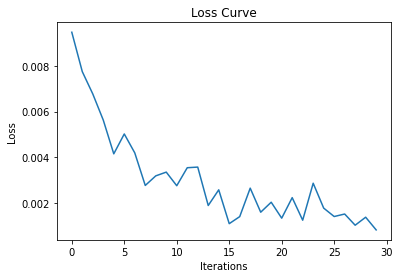

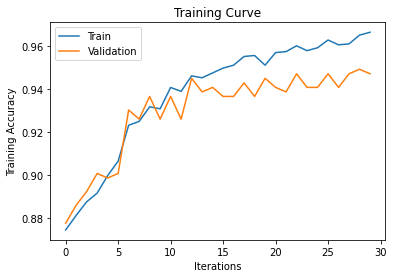

In [ ]:
use_cuda = True

model = CNN_binary()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train(model, batch_size=64, learning_rate=0.00001, num_epochs=30)
plot_curve(30, train_acc, val_acc, losses)

## Testing MIXED

In [ ]:
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, 
                                          num_workers=num_workers, shuffle=True)

best_CNNmodel = CNN_binary()
best_model_path = "/content/gdrive/MyDrive/APS360project/model/model_CNN_binary_bs64_lr1e-05_epoch30"
best_CNNmodel.load_state_dict(torch.load(best_model_path))
best_CNNmodel.cuda()
print("test accuracy: ", get_accuracy(best_CNNmodel, test_loader))

test accuracy:  0.9558823529411765


#AlexNet Binary Classfication


##Model

In [ ]:
class Alex_NN(nn.Module):
      
      
      def __init__(self):
          self.name = "Alex_NN"
          super(Alex_NN, self).__init__()
          self.fc1 = nn.Linear(256*14*11, 2000)
          self.fc2 = nn.Linear(2000, 100)
          self.fc3 = nn.Linear(100, 2)

      def forward(self, x):
          x = x.view(-1, 256*14*11)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = self.fc3(x)
          return x

In [ ]:
class Alex_NN2(nn.Module):
      
      
      def __init__(self):
          self.name = "Alex_NN2"
          super(Alex_NN2, self).__init__()
          self.fc1 = nn.Linear(256*14*11, 200)
          self.fc2 = nn.Linear(200, 10)
          self.fc3 = nn.Linear(10, 2)

      def forward(self, x):
          x = x.view(-1, 256*14*11)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = self.fc3(x)
          return x

In [ ]:
class Alex_NN3(nn.Module):
      
      
      def __init__(self):
          self.name = "Alex_NN3"
          super(Alex_NN3, self).__init__()
          self.fc1 = nn.Linear(256*14*11, 4000)
          self.fc2 = nn.Linear(4000, 400)
          self.fc3 = nn.Linear(400, 40)
          self.fc4 = nn.Linear(40, 2)

      def forward(self, x):
          x = x.view(-1, 256*14*11)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = F.relu(self.fc3(x))
          x = self.fc4(x)
          return x

##Training functions

In [ ]:
# function for training
def train_alex(model, trainset, validset, batch_size=32, learning_rate=0.001, num_epochs=1, path=''):
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_acc, losses,val_acc, epoches = [],[],[],[]

    start_time = time.time()
    print("Training......")
    # training
    epoch = 0 # the number of iterations
    for epoch in range(num_epochs):
        for features, labels in iter(train_loader):        

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              features = features.cuda()
              labels = labels.cuda()
              
            #############################################  
              
            out = model(features)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

  
        # save the current training information
        epoches.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy       
        val_acc.append(get_accuracy(model, valid_loader))  # compute validation accuracy
        
        print(("Epoch {}: Train accuracy: {}, Train loss: {} | Validation accuracy: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   losses[epoch],
                   val_acc[epoch]))
        if val_acc[epoch] > 0.975:
          model_path = "{0}model_{1}_bs{2}_lr{3}_epoch{4}".format(path, model.name, batch_size, learning_rate, epoch)
          torch.save(model.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))   
    return train_acc, val_acc, losses


## Normal vs Pneumonia 

CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.945127719962157, Train loss: 7.912408182164654e-05 | Validation accuracy: 0.8786610878661087
Epoch 2: Train accuracy: 0.9966887417218543, Train loss: 1.6008854800020345e-05 | Validation accuracy: 0.9790794979079498
Epoch 3: Train accuracy: 0.97918637653737, Train loss: 9.313221305262687e-09 | Validation accuracy: 0.9225941422594143
Epoch 4: Train accuracy: 0.9962157048249763, Train loss: 0.0 | Validation accuracy: 0.9351464435146444
Epoch 5: Train accuracy: 0.9990539262062441, Train loss: 9.313225191043273e-10 | Validation accuracy: 0.9769874476987448
Epoch 6: Train accuracy: 1.0, Train loss: 4.926579322273028e-07 | Validation accuracy: 0.9790794979079498
Epoch 7: Train accuracy: 1.0, Train loss: 3.082627415551542e-07 | Validation accuracy: 0.9309623430962343
Epoch 8: Train accuracy: 1.0, Train loss: 0.0 | Validation accuracy: 0.9769874476987448
Epoch 9: Train accuracy: 1.0, Train loss: 3.725281416677717e

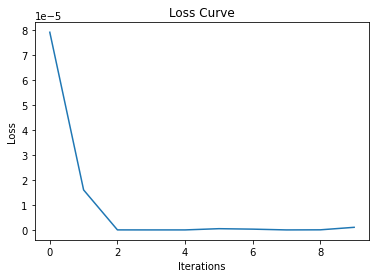

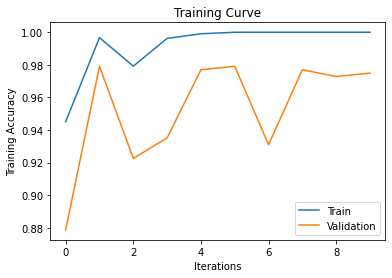

In [ ]:
use_cuda = True

model = Alex_NN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train_alex(model, train_set, valid_set, batch_size=64, learning_rate=0.001, num_epochs=10)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(10, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.9631031220435194, Train loss: 0.0006539981113746762 | Validation accuracy: 0.9623430962343096
Epoch 2: Train accuracy: 0.9877010406811731, Train loss: 7.485742389690131e-05 | Validation accuracy: 0.9707112970711297
Epoch 3: Train accuracy: 0.9962157048249763, Train loss: 0.0005002717371098697 | Validation accuracy: 0.9707112970711297
Epoch 4: Train accuracy: 0.9938505203405865, Train loss: 2.7910571589018218e-05 | Validation accuracy: 0.9748953974895398
Epoch 5: Train accuracy: 0.9985808893093662, Train loss: 2.3875969418440945e-05 | Validation accuracy: 0.9728033472803347
Epoch 6: Train accuracy: 1.0, Train loss: 6.9126167545618955e-06 | Validation accuracy: 0.9769874476987448
Epoch 7: Train accuracy: 1.0, Train loss: 5.7075608310697135e-06 | Validation accuracy: 0.9707112970711297
Epoch 8: Train accuracy: 1.0, Train loss: 4.088169134774944e-06 | Validation accuracy: 0.9790794979079498
Epoch 9: Train acc

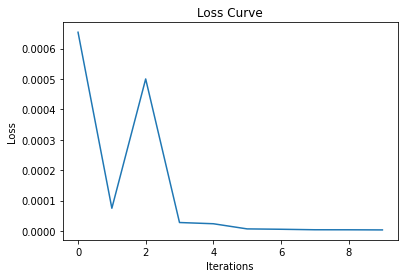

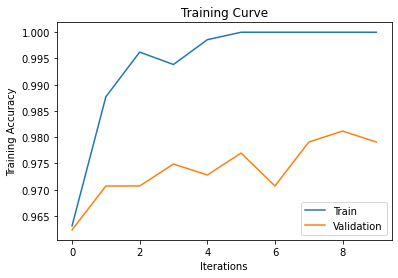

In [ ]:
use_cuda = True

model = Alex_NN()
# save to google drive
path = "/content/gdrive/MyDrive/APS360project/model/"
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train_alex(model, train_set, valid_set, batch_size=128, learning_rate=0.001, num_epochs=10,path=path)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(10, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.9001892147587511, Train loss: 0.0016856725560501218 | Validation accuracy: 0.9058577405857741
Epoch 2: Train accuracy: 0.8982970671712394, Train loss: 0.004421668592840433 | Validation accuracy: 0.8577405857740585
Epoch 3: Train accuracy: 0.9205298013245033, Train loss: 0.0007294091046787798 | Validation accuracy: 0.8598326359832636
Epoch 4: Train accuracy: 0.9432355723746452, Train loss: 7.049452506180387e-06 | Validation accuracy: 0.8661087866108786
Epoch 5: Train accuracy: 0.9328287606433302, Train loss: 7.871069828979671e-05 | Validation accuracy: 0.803347280334728
Epoch 6: Train accuracy: 0.9919583727530747, Train loss: 0.008455907925963402 | Validation accuracy: 0.9665271966527197
Epoch 7: Train accuracy: 0.9555345316934721, Train loss: 0.00028979292255826294 | Validation accuracy: 0.9267782426778243
Epoch 8: Train accuracy: 0.9541154210028382, Train loss: 2.4845501229719957e-06 | Validation accurac

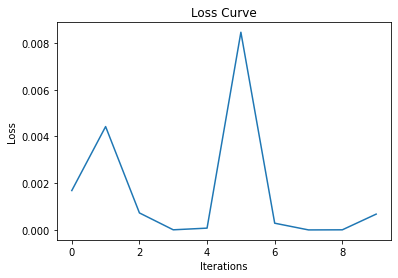

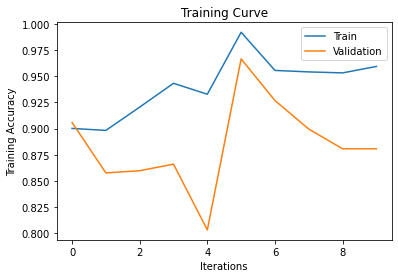

In [ ]:
# Try taining with noise

use_cuda = True

model = Alex_NN()
# save to google drive
path = "/content/gdrive/MyDrive/APS360project/model/Noise_"
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train_alex_noise(model, train_set, valid_set, batch_size=64, learning_rate=0.001, num_epochs=10,path=path)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(10, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.9511848341232227, Train loss: 0.0006869054050184786 | Validation accuracy: 0.801255230125523
Epoch 2: Train accuracy: 0.9824644549763033, Train loss: 0.0003209139686077833 | Validation accuracy: 0.8430962343096234
Epoch 3: Train accuracy: 0.9947867298578199, Train loss: 0.0001999373489525169 | Validation accuracy: 0.9205020920502092
Epoch 4: Train accuracy: 0.9990521327014218, Train loss: 2.0267170839360915e-05 | Validation accuracy: 0.9121338912133892
Epoch 5: Train accuracy: 1.0, Train loss: 1.6217025404330343e-05 | Validation accuracy: 0.8807531380753139
Epoch 6: Train accuracy: 1.0, Train loss: 1.6293050066451542e-05 | Validation accuracy: 0.897489539748954
Epoch 7: Train accuracy: 1.0, Train loss: 2.225535354227759e-05 | Validation accuracy: 0.8849372384937239
Epoch 8: Train accuracy: 1.0, Train loss: 2.8471663426898886e-06 | Validation accuracy: 0.8891213389121339
Epoch 9: Train accuracy: 1.0, Train

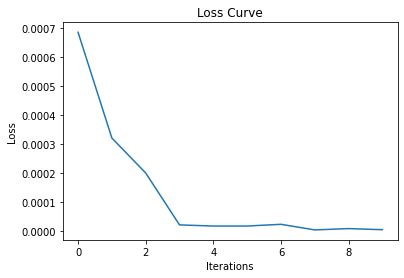

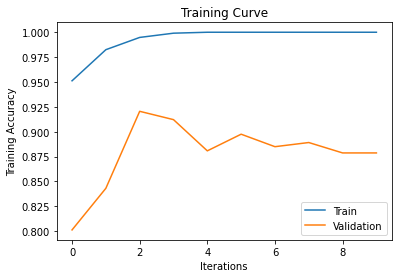

In [ ]:
use_cuda = True

model = Alex_NN()
# save to google drive
path = "new_"
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train_alex(model, train_set ,valid_set , batch_size=64, learning_rate=0.001, num_epochs=10,path=path)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(10, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.9598375451263538, Train loss: 0.0020377212204039097 | Validation accuracy: 0.9451476793248945
Epoch 2: Train accuracy: 0.98014440433213, Train loss: 0.0006279454100877047 | Validation accuracy: 0.9535864978902954
Epoch 3: Train accuracy: 0.980595667870036, Train loss: 0.0027984557673335075 | Validation accuracy: 0.959915611814346
Epoch 4: Train accuracy: 0.9977436823104693, Train loss: 0.0005651239771395922 | Validation accuracy: 0.9683544303797469
Epoch 5: Train accuracy: 0.9990974729241877, Train loss: 0.0004228477773722261 | Validation accuracy: 0.9641350210970464
Epoch 6: Train accuracy: 1.0, Train loss: 9.633763693273067e-05 | Validation accuracy: 0.9746835443037974
Epoch 7: Train accuracy: 1.0, Train loss: 2.4956370907602832e-05 | Validation accuracy: 0.9725738396624473
Epoch 8: Train accuracy: 1.0, Train loss: 3.450439908192493e-05 | Validation accuracy: 0.9662447257383966
Epoch 9: Train accuracy: 

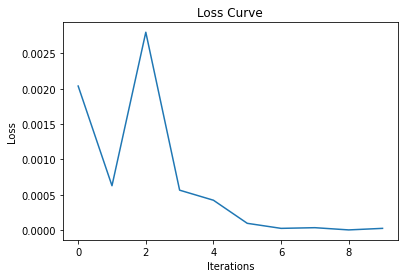

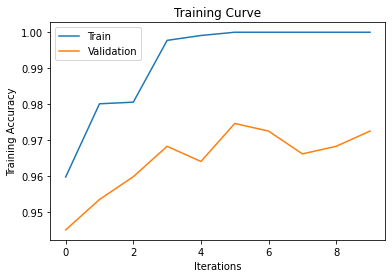

In [ ]:
use_cuda = True

model = Alex_NN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train_alex(model, train_set, valid_set, batch_size=64, learning_rate=0.001, num_epochs=10)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(10, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.9742779783393501, Train loss: 0.0016675535589456558 | Validation accuracy: 0.9514767932489452
Epoch 2: Train accuracy: 0.9661552346570397, Train loss: 0.0012477923883125186 | Validation accuracy: 0.9451476793248945
Epoch 3: Train accuracy: 0.9923285198555957, Train loss: 0.0005531752249225974 | Validation accuracy: 0.9556962025316456
Epoch 4: Train accuracy: 0.993231046931408, Train loss: 0.0007986219716258347 | Validation accuracy: 0.9620253164556962
Epoch 5: Train accuracy: 0.9977436823104693, Train loss: 3.021220618393272e-05 | Validation accuracy: 0.9641350210970464
Epoch 6: Train accuracy: 1.0, Train loss: 9.889477223623544e-05 | Validation accuracy: 0.9641350210970464
Epoch 7: Train accuracy: 1.0, Train loss: 7.233385986182839e-05 | Validation accuracy: 0.9662447257383966
Epoch 8: Train accuracy: 1.0, Train loss: 1.2002823496004567e-05 | Validation accuracy: 0.9662447257383966
Epoch 9: Train accurac

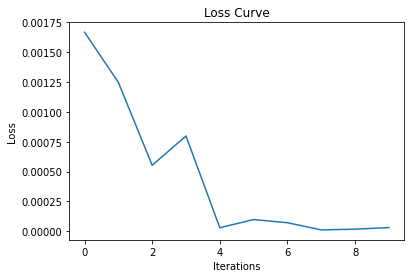

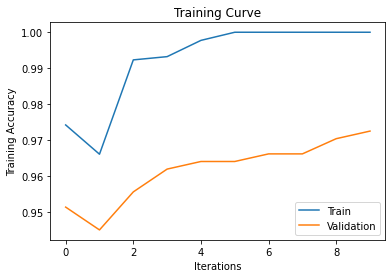

In [ ]:
use_cuda = True

model = Alex_NN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train_alex(model, train_set, valid_set, batch_size=64, learning_rate=0.0001, num_epochs=10)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(10, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.9485559566787004, Train loss: 0.002497968962416053 | Validation accuracy: 0.9345991561181435
Epoch 2: Train accuracy: 0.9544223826714802, Train loss: 0.002212926046922803 | Validation accuracy: 0.9324894514767933
Epoch 3: Train accuracy: 0.9765342960288809, Train loss: 0.0010247164173051715 | Validation accuracy: 0.9556962025316456
Epoch 4: Train accuracy: 0.9846570397111913, Train loss: 0.0005200398154556751 | Validation accuracy: 0.9683544303797469
Epoch 5: Train accuracy: 0.9882671480144405, Train loss: 0.0006698778597638011 | Validation accuracy: 0.9704641350210971
Epoch 6: Train accuracy: 0.9905234657039711, Train loss: 0.00016050580597948283 | Validation accuracy: 0.9683544303797469
Epoch 7: Train accuracy: 0.9936823104693141, Train loss: 0.00016100417997222394 | Validation accuracy: 0.9704641350210971
Epoch 8: Train accuracy: 0.993231046931408, Train loss: 0.00043458864092826843 | Validation accura

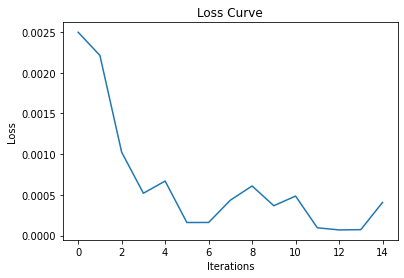

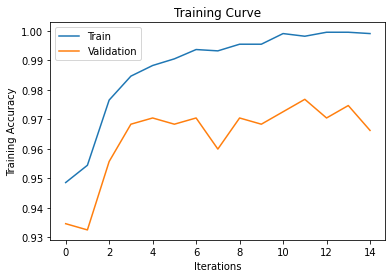

In [ ]:
use_cuda = True

model = Alex_NN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train_alex(model, train_set, valid_set, batch_size=64, learning_rate=1e-5, num_epochs=15)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(15, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.9679602888086642, Train loss: 0.003475621109828353 | Validation accuracy: 0.9535864978902954
Epoch 2: Train accuracy: 0.9566787003610109, Train loss: 0.00045936848619021475 | Validation accuracy: 0.9451476793248945
Epoch 3: Train accuracy: 0.9819494584837545, Train loss: 0.00042600443703122437 | Validation accuracy: 0.959915611814346
Epoch 4: Train accuracy: 0.9824007220216606, Train loss: 0.017327822744846344 | Validation accuracy: 0.9493670886075949
Epoch 5: Train accuracy: 0.9945848375451264, Train loss: 0.00026596980751492083 | Validation accuracy: 0.9641350210970464
Epoch 6: Train accuracy: 0.9986462093862816, Train loss: 0.0001551961904624477 | Validation accuracy: 0.9746835443037974
Epoch 7: Train accuracy: 0.9986462093862816, Train loss: 9.539160237181932e-05 | Validation accuracy: 0.9746835443037974
Epoch 8: Train accuracy: 0.9995487364620939, Train loss: 0.000823241425678134 | Validation accurac

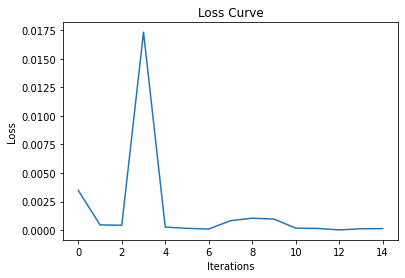

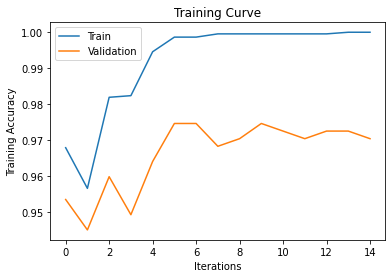

In [ ]:
use_cuda = True

model = Alex_NN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train_alex(model, train_set, valid_set, batch_size=128, learning_rate=1e-5, num_epochs=15)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(15, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.9228339350180506, Train loss: 0.0033736987970769405 | Validation accuracy: 0.9050632911392406
Epoch 2: Train accuracy: 0.9273465703971119, Train loss: 0.0018401372944936156 | Validation accuracy: 0.9113924050632911
Epoch 3: Train accuracy: 0.9462996389891697, Train loss: 0.0019676389638334513 | Validation accuracy: 0.9219409282700421
Epoch 4: Train accuracy: 0.9557761732851986, Train loss: 0.0011210291413590312 | Validation accuracy: 0.9430379746835443
Epoch 5: Train accuracy: 0.9634476534296029, Train loss: 0.0008492449414916337 | Validation accuracy: 0.9472573839662447
Epoch 6: Train accuracy: 0.9666064981949458, Train loss: 0.0009481990709900856 | Validation accuracy: 0.9535864978902954
Epoch 7: Train accuracy: 0.9697653429602888, Train loss: 0.0007750556105747819 | Validation accuracy: 0.9535864978902954
Epoch 8: Train accuracy: 0.9747292418772563, Train loss: 0.0005485427100211382 | Validation accura

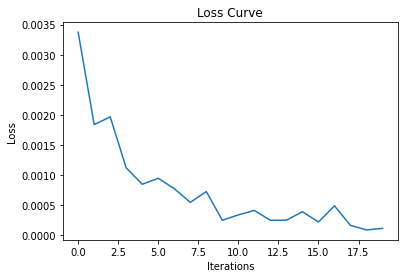

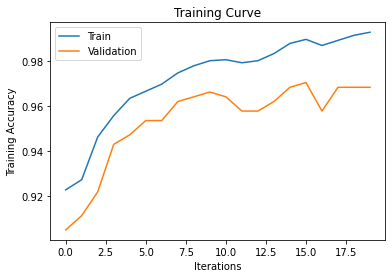

In [ ]:
use_cuda = True

model = Alex_NN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train_alex(model, train_set, valid_set, batch_size=128, learning_rate=5e-6, num_epochs=20)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(20, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.9693140794223827, Train loss: 0.0006689297151751816 | Validation accuracy: 0.9535864978902954
Epoch 2: Train accuracy: 0.9828519855595668, Train loss: 0.00011735958105418831 | Validation accuracy: 0.9641350210970464
Epoch 3: Train accuracy: 0.9923285198555957, Train loss: 0.00036507879849523306 | Validation accuracy: 0.9704641350210971
Epoch 4: Train accuracy: 0.9981949458483754, Train loss: 8.685385546414182e-05 | Validation accuracy: 0.9641350210970464
Epoch 5: Train accuracy: 0.9990974729241877, Train loss: 3.686534910229966e-05 | Validation accuracy: 0.9683544303797469
Epoch 6: Train accuracy: 0.9995487364620939, Train loss: 2.628460424602963e-05 | Validation accuracy: 0.9662447257383966
Epoch 7: Train accuracy: 1.0, Train loss: 1.96225391846383e-05 | Validation accuracy: 0.9746835443037974
Epoch 8: Train accuracy: 1.0, Train loss: 1.9381615857128054e-05 | Validation accuracy: 0.9704641350210971
Epoch

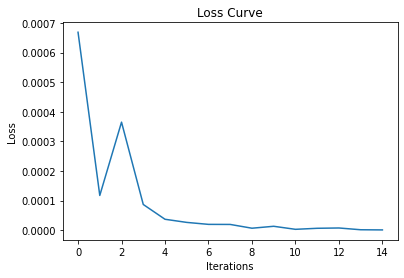

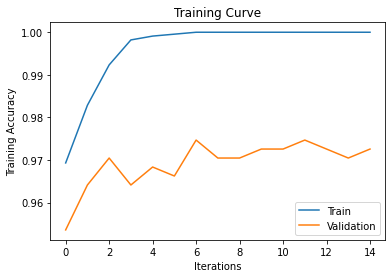

In [ ]:
use_cuda = True

model = Alex_NN3()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train_alex(model, train_set, valid_set, batch_size=128, learning_rate=0.0001, num_epochs=15)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(15, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.9214801444043321, Train loss: 0.002161791082471609 | Validation accuracy: 0.9071729957805907
Epoch 2: Train accuracy: 0.9535198555956679, Train loss: 0.0019092175643891096 | Validation accuracy: 0.9345991561181435
Epoch 3: Train accuracy: 0.9629963898916968, Train loss: 0.0006132661364972591 | Validation accuracy: 0.9514767932489452
Epoch 4: Train accuracy: 0.9715703971119134, Train loss: 0.00039854258648119867 | Validation accuracy: 0.959915611814346
Epoch 5: Train accuracy: 0.98014440433213, Train loss: 0.0007430120604112744 | Validation accuracy: 0.9641350210970464
Epoch 6: Train accuracy: 0.9819494584837545, Train loss: 0.0005513117066584527 | Validation accuracy: 0.9662447257383966
Epoch 7: Train accuracy: 0.9846570397111913, Train loss: 0.00012887037883047014 | Validation accuracy: 0.9662447257383966
Epoch 8: Train accuracy: 0.990072202166065, Train loss: 0.0003013686218764633 | Validation accuracy:

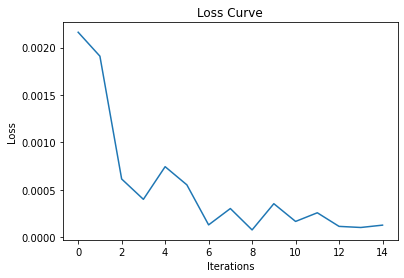

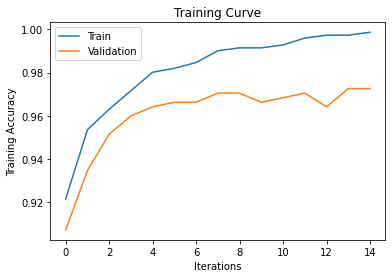

In [ ]:
use_cuda = True

model = Alex_NN3()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train_alex(model, train_set, valid_set, batch_size=128, learning_rate=1e-5, num_epochs=15)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(15, train_acc, val_acc, losses)

##Virus vs. Bacteria

CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.8397129186602871, Train loss: 0.008059932850301266 | Validation accuracy: 0.4955357142857143
Epoch 2: Train accuracy: 0.8416267942583732, Train loss: 0.009001301601529121 | Validation accuracy: 0.4732142857142857
Epoch 3: Train accuracy: 0.8918660287081339, Train loss: 0.0016516817267984152 | Validation accuracy: 0.4732142857142857
Epoch 4: Train accuracy: 0.9760765550239234, Train loss: 0.0022256027441471815 | Validation accuracy: 0.4732142857142857
Epoch 5: Train accuracy: 0.9722488038277513, Train loss: 0.000635862466879189 | Validation accuracy: 0.47098214285714285
Epoch 6: Train accuracy: 0.9679425837320574, Train loss: 0.000519886496476829 | Validation accuracy: 0.4799107142857143
Epoch 7: Train accuracy: 0.9937799043062201, Train loss: 0.0007040618802420795 | Validation accuracy: 0.47098214285714285
Epoch 8: Train accuracy: 0.9976076555023924, Train loss: 0.0007651549531146884 | Validation accuracy

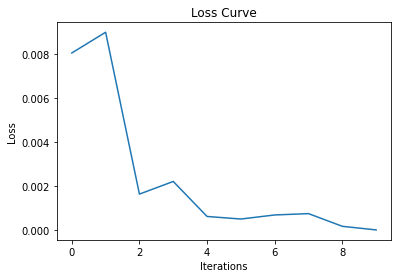

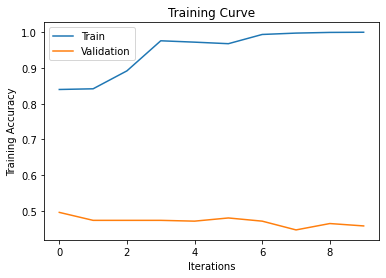

In [ ]:
use_cuda = True

model = Alex_NN()
# save to google drive
path = "/content/gdrive/MyDrive/APS360project/model/VB_"
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train_alex(model, train_set, valid_set, batch_size=64, learning_rate=0.001, num_epochs=10,path=path)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(10, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.6526315789473685, Train loss: 0.010303113609552383 | Validation accuracy: 0.5736607142857143
Epoch 2: Train accuracy: 0.7665071770334928, Train loss: 0.008536549285054207 | Validation accuracy: 0.5848214285714286
Epoch 3: Train accuracy: 0.769377990430622, Train loss: 0.007946270518004894 | Validation accuracy: 0.578125
Epoch 4: Train accuracy: 0.7430622009569378, Train loss: 0.005762668326497078 | Validation accuracy: 0.5803571428571429
Epoch 5: Train accuracy: 0.745933014354067, Train loss: 0.0037411253433674574 | Validation accuracy: 0.5803571428571429
Epoch 6: Train accuracy: 0.784688995215311, Train loss: 0.00508063193410635 | Validation accuracy: 0.5558035714285714
Epoch 7: Train accuracy: 0.6909090909090909, Train loss: 0.004548964556306601 | Validation accuracy: 0.578125
Epoch 8: Train accuracy: 0.7038277511961722, Train loss: 0.004574308171868324 | Validation accuracy: 0.5736607142857143
Epoch 9:

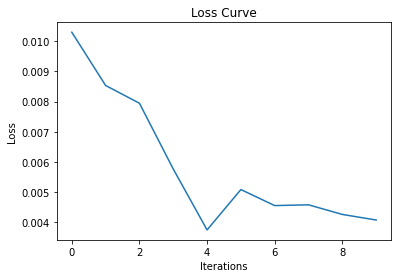

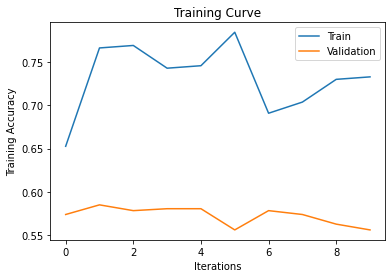

In [ ]:
use_cuda = True

model = Alex_NN()
# save to google drive
path = "/content/gdrive/MyDrive/APS360project/model/VB_"
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train_alex_noise(model, train_set, valid_set, batch_size=64, learning_rate=0.001, num_epochs=10,path=path)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(10, train_acc, val_acc, losses)

## Testing

In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

best_model = Alex_NN()
best_model_path = "/content/gdrive/MyDrive/APS360project/model/model_Alex_NN_bs64_lr0.001_epoch5"
best_model.load_state_dict(torch.load(best_model_path))
best_model.cuda()
print("test accuracy: ", get_accuracy(best_model, test_loader))

test accuracy:  0.7777777777777778


In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

best_model = Alex_NN()
best_model_path = "/content/gdrive/MyDrive/APS360project/model/model_Alex_NN_bs128_lr0.001_epoch8"
best_model.load_state_dict(torch.load(best_model_path))
best_model.cuda()
print("test accuracy: ", get_accuracy(best_model, test_loader))

In [ ]:
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

print("test accuracy: ", get_accuracy(best_model, test_loader))
print("valid accuracy: ", get_accuracy(best_model, valid_loader))

test accuracy:  0.9274193548387096
valid accuracy:  0.9790794979079498


In [ ]:
test_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

best_model = Alex_NN()
best_model_path = "/content/gdrive/MyDrive/APS360project/model/model_Alex_NN_bs64_lr0.001_epoch5"
best_model.load_state_dict(torch.load(best_model_path))
best_model.cuda()
print("train accuracy: ", get_accuracy(best_model, test_loader))

train accuracy:  0.966824644549763


In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

best_model = Alex_NN()
best_model_path = "/content/new_model_Alex_NN_bs64_lr0.001_epoch3"
best_model.load_state_dict(torch.load(best_model_path))
best_model.cuda()
print("new test accuracy: ", get_accuracy(best_model, test_loader))

new test accuracy:  0.9495967741935484


#FINAL

##model

In [ ]:
class Alex_NN(nn.Module):
      
      
      def __init__(self):
          self.name = "Alex_NN"
          super(Alex_NN, self).__init__()
          self.fc1 = nn.Linear(256*14*11, 2000)
          self.fc2 = nn.Linear(2000, 100)
          self.fc3 = nn.Linear(100, 2)

      def forward(self, x):
          x = x.view(-1, 256*14*11)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = self.fc3(x)
          return x

In [ ]:
'''
smaller model
'''

class Alex_NN2(nn.Module):
      
      
      def __init__(self):
          self.name = "Alex_NN2"
          super(Alex_NN2, self).__init__()
          self.fc1 = nn.Linear(256*14*11, 200)
          self.fc2 = nn.Linear(200, 10)
          self.fc3 = nn.Linear(10, 2)

      def forward(self, x):
          x = x.view(-1, 256*14*11)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = self.fc3(x)
          return x

## Training

###first model

CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.9228339350180506, Train loss: 0.0031667626462876797 | Validation accuracy: 0.9008438818565401, Validation loss: 0.003292826237156987
Epoch 2: Train accuracy: 0.9332129963898917, Train loss: 0.002101578051224351 | Validation accuracy: 0.9113924050632911, Validation loss: 0.0017379799392074347
Epoch 3: Train accuracy: 0.9481046931407943, Train loss: 0.0021241188514977694 | Validation accuracy: 0.9282700421940928, Validation loss: 0.0009743327973410487
Epoch 4: Train accuracy: 0.9580324909747292, Train loss: 0.0010329956421628594 | Validation accuracy: 0.9472573839662447, Validation loss: 0.0017768251709640026
Epoch 5: Train accuracy: 0.9616425992779783, Train loss: 0.0011760720517486334 | Validation accuracy: 0.9535864978902954, Validation loss: 0.0007510809227824211
Epoch 6: Train accuracy: 0.9661552346570397, Train loss: 0.0005835790070705116 | Validation accuracy: 0.9620253164556962, Validation loss: 0.0

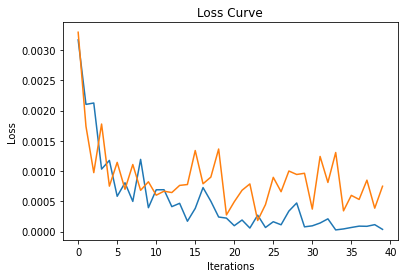

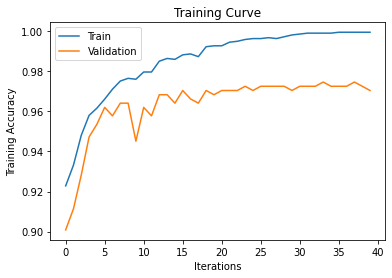

In [ ]:
'''
这个图更好看一点
'''
use_cuda = True

model = Alex_NN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses,val_loss = train_alex(model, train_set, valid_set, batch_size=128, learning_rate=5e-6, num_epochs=40)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(40, train_acc, val_acc, losses,val_loss)

CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.9138086642599278, Train loss: 0.0031371000222861767 | Validation accuracy: 0.8881856540084389, Validation loss: 0.0029379890765994787
Epoch 2: Train accuracy: 0.9341155234657039, Train loss: 0.0020608152262866497 | Validation accuracy: 0.9092827004219409, Validation loss: 0.001927240053191781
Epoch 3: Train accuracy: 0.9453971119133574, Train loss: 0.0015715716872364283 | Validation accuracy: 0.930379746835443, Validation loss: 0.001647226046770811
Epoch 4: Train accuracy: 0.9571299638989169, Train loss: 0.0008061124244704843 | Validation accuracy: 0.9430379746835443, Validation loss: 0.0010642868001013994
Epoch 5: Train accuracy: 0.9634476534296029, Train loss: 0.0008259235182777047 | Validation accuracy: 0.9514767932489452, Validation loss: 0.0009342842386104167
Epoch 6: Train accuracy: 0.9693140794223827, Train loss: 0.0008496108348481357 | Validation accuracy: 0.9535864978902954, Validation loss: 0.00

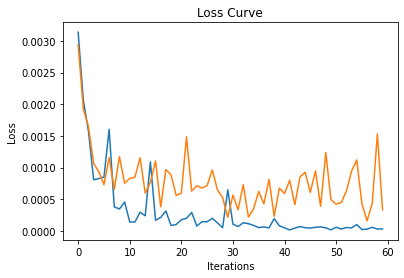

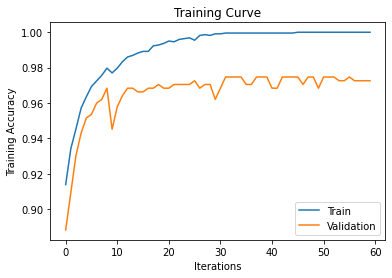

In [ ]:
'''
model 用的是这里的
'''

use_cuda = True

model = Alex_NN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses, val_loss = train_alex(model, train_set, valid_set, batch_size=128, learning_rate=5e-6, num_epochs=60)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(60, train_acc, val_acc, losses, val_loss)

### smaller model

CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.8786101083032491, Train loss: 0.0045240940526127815 | Validation accuracy: 0.8481012658227848
Epoch 2: Train accuracy: 0.9192238267148014, Train loss: 0.0037600137293338776 | Validation accuracy: 0.8924050632911392
Epoch 3: Train accuracy: 0.9187725631768953, Train loss: 0.002943558618426323 | Validation accuracy: 0.8924050632911392
Epoch 4: Train accuracy: 0.9250902527075813, Train loss: 0.0026613655500113964 | Validation accuracy: 0.8987341772151899
Epoch 5: Train accuracy: 0.9282490974729242, Train loss: 0.0027006969321519136 | Validation accuracy: 0.9113924050632911
Epoch 6: Train accuracy: 0.9345667870036101, Train loss: 0.002572691533714533 | Validation accuracy: 0.9135021097046413
Epoch 7: Train accuracy: 0.9431407942238267, Train loss: 0.0022055967710912228 | Validation accuracy: 0.9156118143459916
Epoch 8: Train accuracy: 0.9444945848375451, Train loss: 0.0016768373316153884 | Validation accuracy

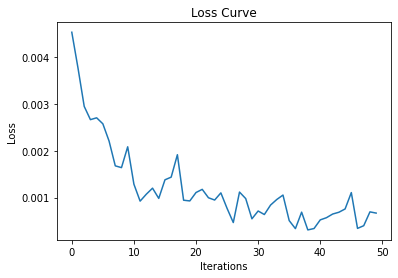

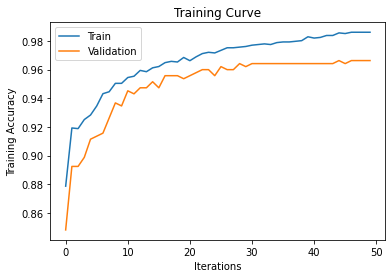

In [ ]:
use_cuda = True

model = Alex_NN2()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses = train_alex(model, train_set, valid_set, batch_size=128, learning_rate=5e-6, num_epochs=50)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(50, train_acc, val_acc, losses)

CUDA is available!  Training on GPU ...
Training......
Epoch 1: Train accuracy: 0.7143501805054152, Train loss: 0.004656793549656868 | Validation accuracy: 0.6919831223628692, Validation loss: 0.004711877554655075
Epoch 2: Train accuracy: 0.7725631768953068, Train loss: 0.004142784513533115 | Validation accuracy: 0.7573839662447257, Validation loss: 0.004267728887498379
Epoch 3: Train accuracy: 0.8384476534296029, Train loss: 0.0037263936828821898 | Validation accuracy: 0.810126582278481, Validation loss: 0.003888076636940241
Epoch 4: Train accuracy: 0.8501805054151624, Train loss: 0.003920555580407381 | Validation accuracy: 0.8185654008438819, Validation loss: 0.00403353339061141
Epoch 5: Train accuracy: 0.8619133574007221, Train loss: 0.004122180864214897 | Validation accuracy: 0.8375527426160337, Validation loss: 0.003966222051531076
Epoch 6: Train accuracy: 0.8957581227436823, Train loss: 0.004129794891923666 | Validation accuracy: 0.8649789029535865, Validation loss: 0.00359899527

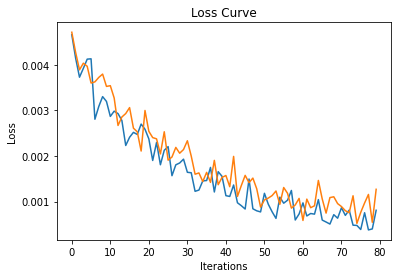

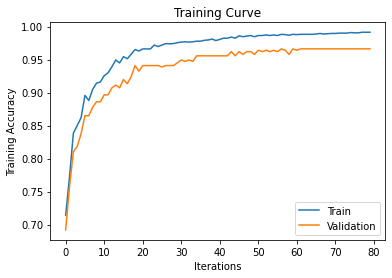

In [ ]:
use_cuda = True

model = Alex_NN2()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#Tunning hyperparameters
train_acc, val_acc, losses, val_loss = train_alex(model, train_set, valid_set, batch_size=128, learning_rate=5e-6, num_epochs=80)
# Uses 'plot_curve' from 'primary_model' section
plot_curve(80, train_acc, val_acc, losses, val_loss)

##Acuracy

In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

best_model = Alex_NN()
best_model_path = "/content/gdrive/MyDrive/APS360project/model/Final/model_Alex_NN_bs128_lr5e-06_epoch48"
best_model.load_state_dict(torch.load(best_model_path))
best_model.cuda()
print("test accuracy: ", get_accuracy(best_model, test_loader))

test accuracy:  0.9705882352941176


In [ ]:
best_model = Alex_NN2()
best_model_path = "/content/gdrive/MyDrive/APS360project/model/Final/model_Alex_NN_Small_bs128_lr5e-06_epoch70"
best_model.load_state_dict(torch.load(best_model_path))
best_model.cuda()
print("small model test accuracy: ", get_accuracy(best_model, test_loader))

small model test accuracy:  0.9642857142857143


## confusion matrix

In [ ]:
def get_accuracy_label(net, loader, l):
  correct = 0
  total = 0
  for imgs, labels in loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    output = net(imgs)
    pred = output.max(1, keepdim=True)[1] #select index with maximum prediction score
    if (l=='normal'):
      for j in labels:
        if (j==0):
          correct += pred.eq(labels.view_as(pred)).sum().item()
          total += imgs.shape[0]
    if (l=='pneumonia'):
      for j in labels:
        if (j==1):
          correct += pred.eq(labels.view_as(pred)).sum().item()
          total += imgs.shape[0]
  return correct / total

In [ ]:
print("true positive rate is ", get_accuracy_label(best_model, test_loader,'normal'))
print("false positive  rate is ", 1-get_accuracy_label(best_model, test_loader,'normal'))
print("true negative rate is ", get_accuracy_label(best_model, test_loader,'pneumonia'))
print("false negative rate is ", 1-get_accuracy_label(best_model, test_loader,'pneumonia'))

true positive rate is  0.9690617417093557
false positive  rate is  0.03080345106497706
true negative rate is  0.9718878248974008
false negative rate is  0.02982216142270866


In [ ]:
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=True)
# alex_nn
print("true positive rate is ", get_accuracy_label(best_model, valid_loader,'normal'))
print("false positivee rate is ", 1-get_accuracy_label(best_model, valid_loader,'normal'))
print("true negative rate is ", get_accuracy_label(best_model, valid_loader,'pneumonia'))
print("false negative rate is ", 1-get_accuracy_label(best_model, valid_loader,'pneumonia'))

true positive rate is  0.9747910672694889
false positivee rate is  0.024789973832805345
true negative rate is  0.9736274113044652
false negative rate is  0.02609776304888156


In [ ]:
# cnn
valid_path = '/content/gdrive/MyDrive/APS360project/Data/Val_mix'
transform = transforms.Compose([transforms.Resize((500,400)), 
                                transforms.ToTensor()])
validset = torchvision.datasets.ImageFolder(valid_path, transform=transform)
# Prepare Dataloader
batch_size = 64
num_workers = 1
# this valid loader is not for alexnet features
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
best_model_cnn = CNN_binary()
best_model_cnn_path = "/content/gdrive/MyDrive/APS360project/model/Final/model_CNN_binary_bs128_lr0.001_epoch30"
best_model_cnn.load_state_dict(torch.load(best_model_cnn_path))
best_model_cnn.cuda()
print("true positive rate is ", get_accuracy_label(best_model_cnn, valid_loader,'normal'))
print("false positivee rate is ", 1-get_accuracy_label(best_model_cnn, valid_loader,'normal'))
print("true negative rate is ", get_accuracy_label(best_model_cnn, valid_loader,'pneumonia'))
print("false negative rate is ", 1-get_accuracy_label(best_model_cnn, valid_loader,'pneumonia'))

true positive rate is  0.9583728813559322
false positivee rate is  0.038950500405734334
true negative rate is  0.9577360021639167
false negative rate is  0.04165539626724368


## Qualitative Result

In [ ]:
k=0
fig = plt.figure()
classes = ['Normal','Pneunomia']

#predictions
for images, labels in test_loader:
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    prediction = best_model(images)
    pred = prediction.max(1, keepdim=True)[1]
    print("prediction for ", classes[labels[k]]," is ",classes[int(pred[k])])
    k += 1
    if k > 5:
        break
    

prediction for  Pneunomia  is  Pneunomia
prediction for  Normal  is  Normal
prediction for  Normal  is  Normal
prediction for  Pneunomia  is  Pneunomia
prediction for  Normal  is  Normal
prediction for  Pneunomia  is  Pneunomia


<Figure size 432x288 with 0 Axes>

In [ ]:
unseen_path = '/content/gdrive/MyDrive/APS360project/Data/Unseen2'

transform = transforms.Compose([transforms.Resize((500,400)), 
                                transforms.ToTensor()])


unseenset = torchvision.datasets.ImageFolder(unseen_path, transform=transform)

batch_size = 1 # save 1 file at a time, hence batch_size = 1
num_workers = 1
unseen_transfer_loader = torch.utils.data.DataLoader(unseenset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)



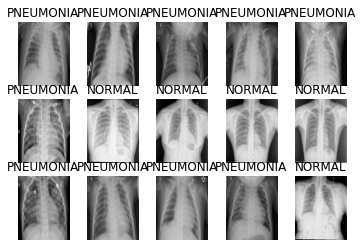

In [ ]:
k = 0
classes = ['NORMAL','PNEUMONIA']
fig = plt.figure()
for images, labels in unseen_transfer_loader:
    image = images[0]
    #img = np.transpose(image)
    img = np.transpose(image, [1,2,0])
    sub = fig.add_subplot(3, 5, k+1)
    plt.axis('off')
    sub.set_title(classes[labels]) # add label to each image
    plt.imshow(img, cmap='Greys')

    k += 1
    if k > 14:
        break

In [ ]:
unseen_transfer_path = '/content/gdrive/MyDrive/APS360project/Data/Unseen2_Transfer'
features_to_folder(unseen_transfer_loader, unseen_transfer_path)

In [ ]:
unseen_transfer_set = torchvision.datasets.DatasetFolder(unseen_transfer_path, loader=torch.load, extensions=('.tensor'))
print("unseen set size: ", len(unseen_transfer_set))

unseen set size:  400


In [ ]:
unseen_transfer_loader = torch.utils.data.DataLoader(unseen_transfer_set, batch_size=batch_size, shuffle=True)

use_cuda = True
best_model = Alex_NN()
best_model_path = "/content/gdrive/MyDrive/APS360project/model/Final/model_Alex_NN_bs128_lr5e-06_epoch48"
best_model.load_state_dict(torch.load(best_model_path))
best_model.cuda()
print("test accuracy: ", get_accuracy(best_model, unseen_transfer_loader))

test accuracy:  0.765


In [ ]:
best_model_small = Alex_NN2()
best_model_small_path = "/content/gdrive/MyDrive/APS360project/model/Final/model_Alex_NN_Small_bs128_lr5e-06_epoch70"
best_model_small.load_state_dict(torch.load(best_model_small_path))
best_model_small.cuda()
print("small model test accuracy: ", get_accuracy(best_model_small, unseen_transfer_loader))

small model test accuracy:  0.745


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive

Mounted at /content/gdrive
MyDrive


In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image

import matplotlib.image as mpimg

#Demonstration

## Example Data

### Images

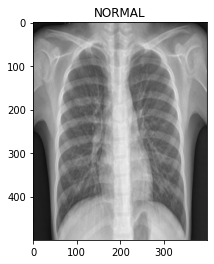

In [ ]:
test_img_path = '/content/gdrive/MyDrive/APS360project/Data/Test_mix' 
transform = transforms.Compose([transforms.Resize((500,400)), 
                                transforms.ToTensor()])
test_set_img = torchvision.datasets.ImageFolder(test_img_path, transform=transform)

classes = ['NORMAL','PNEUMONIA']
fig = plt.figure()
img = np.transpose(test_set_img[0][0], [1,2,0])
sub = fig.add_subplot(1,1,1)
sub.set_title(classes[test_set_img[0][1]])
plt.imshow(img, cmap='Greys')

### Transferred Alexnet Features

In [ ]:
test_transfer_path = '/content/gdrive/MyDrive/APS360project/Data/Transfer_mix/Test' 
test_set = torchvision.datasets.DatasetFolder(test_transfer_path, loader=torch.load, extensions=('.tensor'))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [ ]:
test_set[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.8707,  ..., 0.5979, 0.1986, 0.0000],
          [0.0000, 0.0000, 1.2563,  ..., 0.9988, 0.9988, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1832, 0.1832, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2285, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...,

In [ ]:
test_set[0][0].shape


torch.Size([256, 14, 11])

##Model

In [ ]:
class Alex_NN(nn.Module):
      
      
      def __init__(self):
          self.name = "Alex_NN"
          super(Alex_NN, self).__init__()
          self.fc1 = nn.Linear(256*14*11, 2000)
          self.fc2 = nn.Linear(2000, 100)
          self.fc3 = nn.Linear(100, 2)

      def forward(self, x):
          x = x.view(-1, 256*14*11)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = self.fc3(x)
          return x

In [ ]:
best_model = Alex_NN()
best_model_path = "/content/gdrive/MyDrive/APS360project/model/Final/model_Alex_NN_bs128_lr5e-06_epoch48"
best_model.load_state_dict(torch.load(best_model_path))
best_model.cuda()

Alex_NN(
  (fc1): Linear(in_features=39424, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)

##Testing

###Output

In [ ]:
use_cuda = True
for features, labels in test_loader:
  features_0 = features[0].cuda()
  prediction = best_model(features_0)
  pred = prediction.max(1, keepdim=True)[1]
  print("prediction for ", classes[labels[0]]," is ",classes[int(pred)])
  break

prediction for  NORMAL  is  NORMAL


###Accuracy

In [ ]:
def get_accuracy(net, loader):
  correct = 0
  total = 0
  for features, labels in loader:
    if use_cuda and torch.cuda.is_available():
      features = features.cuda()
      labels = labels.cuda()
    output = net(features)
    pred = output.max(1, keepdim=True)[1] #select index with maximum prediction score
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += features.shape[0]
  return correct / total

In [ ]:
use_cuda = True
print("test accuracy: ", get_accuracy(best_model, test_loader))

test accuracy:  0.9705882352941176


#Time Test

In [ ]:
start_time = time.time()
test_img_path = '/content/gdrive/MyDrive/APS360project/Data/Test_mix' 
transform = transforms.Compose([transforms.Resize((500,400)), 
                                transforms.ToTensor()])
test_set_img = torchvision.datasets.ImageFolder(test_img_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set_img, batch_size=64, 
                                          num_workers=1, shuffle=False)

load_time = time.time()

for img, labels in test_loader:
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())
    features = features.cuda()
    labels = labels.cuda()
    output = best_model(features)
end_time = time.time()

print(len(test_set_img))
print("Load: ", load_time-start_time)
print("Run: ", end_time-load_time)

476
Load:  0.011679410934448242
Run:  63.35455131530762
